[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/neelnanda-io/TransformerLens/blob/main/demos/Exploratory_Analysis_Demo.ipynb)

# Exploratory Analysis Demo

This notebook demonstrates how to use the
[TransformerLens](https://github.com/neelnanda-io/TransformerLens/) library to perform exploratory
analysis. The notebook tries to replicate the analysis of the Indirect Object Identification circuit
in the [Interpretability in the Wild](https://arxiv.org/abs/2211.00593) paper.

## Tips for Reading This

* If running in Google Colab, go to Runtime > Change Runtime Type and select GPU as the hardware
accelerator.
* Look up unfamiliar terms in [the mech interp explainer](https://neelnanda.io/glossary)
* You can run all this code for yourself
* The graphs are interactive
* Use the table of contents pane in the sidebar to navigate (in Colab) or VSCode's "Outline" in the
  explorer tab.
* Collapse irrelevant sections with the dropdown arrows
* Search the page using the search in the sidebar (with Colab) not CTRL+F

## Setup

### Environment Setup (ignore)

**You can ignore this part:** It's just for use internally to setup the tutorial in different
environments. You can delete this section if using in your own repo.

In [2]:

# Detect if we're running in Google Colab
try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
except:
    IN_COLAB = False

# Install if in Colab
if IN_COLAB:
    %pip install transformer_lens
    %pip install circuitsvis
    # Install a faster Node version
    !curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs  # noqa

# Hot reload in development mode & not running on the CD
if not IN_COLAB:
    from IPython import get_ipython
    ip = get_ipython()
    if not ip.extension_manager.loaded:
        ip.extension_manager.load('autoreload')
        %autoreload 2


### Imports

In [3]:
from functools import partial
from typing import List, Optional, Union

import einops
import numpy as np
import plotly.express as px
import plotly.io as pio
import torch
from circuitsvis.attention import attention_heads
from fancy_einsum import einsum
from IPython.display import HTML, IFrame
from jaxtyping import Float

import transformer_lens.utils as utils
from transformer_lens import ActivationCache, HookedTransformer

/Users/alokbeniwal/nanda-mech-interp/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### PyTorch Setup

We turn automatic differentiation off, to save GPU memory, as this notebook focuses on model inference not model training.

In [4]:
torch.set_grad_enabled(False)
print("Disabled automatic differentiation")

Disabled automatic differentiation


### Plotting Helper Functions (ignore)

Some plotting helper functions are included here (for simplicity).

In [5]:
def imshow(tensor, **kwargs):
    px.imshow(
        utils.to_numpy(tensor),
        color_continuous_midpoint=0.0,
        color_continuous_scale="RdBu",
        **kwargs,
    ).show()


def line(tensor, **kwargs):
    px.line(
        y=utils.to_numpy(tensor),
        **kwargs,
    ).show()


def scatter(x, y, xaxis="", yaxis="", caxis="", **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(
        y=y,
        x=x,
        labels={"x": xaxis, "y": yaxis, "color": caxis},
        **kwargs,
    ).show()

## Introduction

This is a demo notebook for [TransformerLens](https://github.com/neelnanda-io/TransformerLens), a library for mechanistic interpretability of GPT-2 style transformer language models. A core design principle of the library is to enable exploratory analysis - one of the most fun parts of mechanistic interpretability compared to normal ML is the extremely short feedback loops! The point of this library is to keep the gap between having an experiment idea and seeing the results as small as possible, to make it easy for **research to feel like play** and to enter a flow state.

The goal of this notebook is to demonstrate what exploratory analysis looks like in practice with the library. I use my standard toolkit of basic mechanistic interpretability techniques to try interpreting a real circuit in GPT-2 small. Check out [the main demo](https://colab.research.google.com/github/neelnanda-io/TransformerLens/blob/main/demos/Main_Demo.ipynb) for an introduction to the library and how to use it.

Stylistically, I will go fairly slowly and explain in detail what I'm doing and why, aiming to help convey how to do this kind of research yourself! But the code itself is written to be simple and generic, and easy to copy and paste into your own projects for different tasks and models.

Details tags contain asides, flavour + interpretability intuitions. These are more in the weeds and you don't need to read them or understand them, but they're helpful if you want to learn how to do mechanistic interpretability yourself! I star the ones I think are most important.
<details><summary>(*) Example details tag</summary>Example aside!</details>

### Indirect Object Identification

The first step when trying to reverse engineer a circuit in a model is to identify *what* capability
I want to reverse engineer. Indirect Object Identification is a task studied in Redwood Research's
excellent [Interpretability in the Wild](https://arxiv.org/abs/2211.00593) paper (see [my interview
with the authors](https://www.youtube.com/watch?v=gzwj0jWbvbo) or [Kevin Wang's Twitter
thread](https://threadreaderapp.com/thread/1587601532639494146.html) for an overview). The task is
to complete sentences like "After John and Mary went to the shops, John gave a bottle of milk to"
with " Mary" rather than " John".

In the paper they rigorously reverse engineer a 26 head circuit, with 7 separate categories of heads
used to perform this capability. Their rigorous methods are fairly involved, so in this notebook,
I'm going to skimp on rigour and instead try to speed run the process of finding suggestive evidence
for this circuit!

The circuit they found roughly breaks down into three parts:
1. Identify what names are in the sentence
2. Identify which names are duplicated
3. Predict the name that is *not* duplicated

The first step is to load in our model, GPT-2 Small, a 12 layer and 80M parameter transformer with `HookedTransformer.from_pretrained`. The various flags are simplifications that preserve the model's output but simplify its internals.

In [27]:
MODEL_NAME = "EleutherAI/gpt-neo-2.7B"
# NBVAL_IGNORE_OUTPUT
model = HookedTransformer.from_pretrained(
    MODEL_NAME,
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)
# add left padding
model.tokenizer.padding_side = "left"
model.set_tokenizer(default_padding_side="left", tokenizer=model.tokenizer)
# Get the default device used
device: torch.device = utils.get_device()

Loaded pretrained model EleutherAI/gpt-neo-2.7B into HookedTransformer


The next step is to verify that the model can *actually* do the task! Here we use `utils.test_prompt`, and see that the model is significantly better at predicting Mary than John!

<details><summary>Asides:</summary>

Note: If we were being careful, we'd want to run the model on a range of prompts and find the average performance

`prepend_bos` is a flag to add a BOS (beginning of sequence) to the start of the prompt. GPT-2 was not trained with this, but I find that it often makes model behaviour more stable, as the first token is treated weirdly.
</details>

We now want to find a reference prompt to run the model on. Even though our ultimate goal is to reverse engineer how this behaviour is done in general, often the best way to start out in mechanistic interpretability is by zooming in on a concrete example and understanding it in detail, and only *then* zooming out and verifying that our analysis generalises.

We'll run the model on 4 instances of this task, each prompt given twice - one with the first name as the indirect object, one with the second name. To make our lives easier, we'll carefully choose prompts with single token names and the corresponding names in the same token positions.

<details> <summary>(*) <b>Aside on tokenization</b></summary>

We want models that can take in arbitrary text, but models need to have a fixed vocabulary. So the solution is to define a vocabulary of **tokens** and to deterministically break up arbitrary text into tokens. Tokens are, essentially, subwords, and are determined by finding the most frequent substrings - this means that tokens vary a lot in length and frequency!

Tokens are a *massive* headache and are one of the most annoying things about reverse engineering language models... Different names will be different numbers of tokens, different prompts will have the relevant tokens at different positions, different prompts will have different total numbers of tokens, etc. Language models often devote significant amounts of parameters in early layers to convert inputs from tokens to a more sensible internal format (and do the reverse in later layers). You really, really want to avoid needing to think about tokenization wherever possible when doing exploratory analysis (though, of course, it's relevant later when trying to flesh out your analysis and make it rigorous!). HookedTransformer comes with several helper methods to deal with tokens: `to_tokens, to_string, to_str_tokens, to_single_token, get_token_position`

Alok: interesting that tokens are avoided by model too, it converts out and in of them and devotes params to it

**Exercise:** I recommend using `model.to_str_tokens` to explore how the model tokenizes different strings. In particular, try adding or removing spaces at the start, or changing capitalization - these change tokenization!</details>

Alok: found that GPT Neo 1.3B doesn't seem to get syntax/semantics, but otherwise seems to understand opposition. TODO include the screenshots using `utils.test_prompt`.



In [33]:
from typing import NamedTuple

from regex import D
from sympy import PermutationMatrix


def unzip(tuples):
    return zip(*tuples)


class Answer(NamedTuple):
    correct: str
    incorrect: str


In [ ]:


prompts_and_answers: list[tuple[str, Answer]] = [
    ("\n\nInstead of turning left, the character turned", Answer(" right", " left")),
    ("\nThe bird did not fly up, it flew", Answer(" down", " up")),
    ("\n\nThe data is not discrete, it is", Answer(" continuous", " discrete")),
    ("She did not walk towards the right, she moved to the", Answer(" left", " right")),
    ("He did not walk towards the left, he moved to the", Answer(" right", " left")),
    ("\n\nThe data is not continuous, it is", Answer(" discrete", " continuous")),
    ("\nTo avoid going down, the climber went", Answer(" up", " down")),
    ("\nTo avoid going up, the climber went", Answer(" down", " up")),
    ("The vehicle couldn't turn left, so it turned", Answer(" right", " left")),
    ("The vehicle couldn't turn right, so it turned", Answer(" left", " right")),
    # ("syntax is dual to", Answer(" semantics", " syntax")),
    # TODO(alok): HACK. it gets the previous one, maybe bc 'syntax and semantics' is a set phrase but 'semantics and syntax' isn't
    # ("semantics is dual to", Answer(" syntax", " semantics")),
    ("he feels hot, but i feel", Answer(" cold", " hot")),
    ("\nThe sun did not rise in the east, it rose in the", Answer(" west", " east")),
    (
        "\n\nThe player did not pass the ball forward, they passed it",
        Answer(" backward", " forward"),
    ),
    # ("\n The water did not freeze, it", Answer(" boiled", " froze")),
    ("\n\nThe door didn't open inward, it swung", Answer(" outward", " inward")),
    # ("\nInstead of accepting the offer, she", Answer(" rejected", " accepted")),  # does poorly here, maybe too open ended?
]


prompts, answers = unzip(prompts_and_answers)
print(prompts, answers)
prompt_tokens = [model.to_tokens(prompt) for prompt in prompts]
answer_tokens = torch.tensor(
    [
        (model.to_single_token(a.correct), model.to_single_token(a.incorrect))
        for a in answers
    ],
    device=device,
)

**Gotcha**: It's important that all of your prompts have the same number of tokens. If they're different lengths, then the position of the "final" logit where you can check logit difference will differ between prompts, and this will break the below code. The easiest solution is just to choose your prompts carefully to have the same number of tokens (you can eg add filler words like The, or newlines to start).

There's a range of other ways of solving this, eg you can index more intelligently to get the final logit. A better way is to just use left padding by setting `model.tokenizer.padding_side = 'left'` before tokenizing the inputs and running the model; this way, you can use something like `logits[:, -1, :]` to easily access the final token outputs without complicated indexing. TransformerLens checks the value of `padding_side` of the tokenizer internally, and if the flag is set to be `'left'`, it adjusts the calculation of absolute position embedding and causal masking accordingly.

In this demo, though, we stick to using the prompts of the same number of tokens because we want to show some visualisations aggregated along the batch dimension later in the demo.

In [29]:
def leftpad(strs: list[str], model, pad_char: str = "\n") -> list[str]:
    """Left pads each string in the list to the length of the longest string."""
    lens = [len(model.to_str_tokens(s)) for s in strs]
    maxlen = max(lens)
    out = [pad_char * (maxlen - len(model.to_str_tokens(s))) + s for s in strs]

    # TODO(alok): HACK sometimes the tokenizer merges newlines and adding a newline doesn't increase token count, so run until everything is same tokenized length.
    while len(set(lens)) > 1:
        out = leftpad(out, model)
        lens = [len(model.to_str_tokens(s)) for s in out]
    return out

We now run the model on these prompts and use `run_with_cache` to get both the logits and a cache of all internal activations for later analysis

In [30]:
tokens = model.to_tokens(leftpad(prompts, model), prepend_bos=True)
original_logits: Float[torch.Tensor, "batch tokens vocab"]
# Run the model and cache all activations
original_logits, cache = model.run_with_cache(tokens)

We'll later be evaluating how model performance differs upon performing various interventions, so it's useful to have a metric to measure model performance. Our metric here will be the **logit difference**, the difference in logit between the indirect object's name and the subject's name (eg, `logit(Mary)-logit(John)`).

Alok: my first metric will be the difference between the logits between a word and its opposite. For more robustness, we could compare to a set of opposing words and take some average.

In [31]:
def logits_to_avg_logit_diff(
    logits: Float[torch.Tensor, "batch tokens vocab"],
    answer_tokens: Float[torch.Tensor, "batch 2"],
    per_prompt=False,
):
    # Only the final logits are relevant for the answer
    final_logits: Float[torch.Tensor, "batch vocab"] = logits[:, -1, :]

    answer_logits = final_logits.gather(dim=-1, index=answer_tokens)
    correct_logits, incorrect_logits = answer_logits[:, 0], answer_logits[:, 1]
    answer_logit_diff = correct_logits - incorrect_logits
    if per_prompt:
        return answer_logit_diff
    else:
        return answer_logit_diff.mean()

Per prompt logit difference: tensor([ 2.1070,  1.7540,  3.3410,  2.6260,  2.8600,  3.2700, -0.4260,  2.2520,
         3.1950,  2.4530,  2.6580,  4.1310,  1.6190,  0.7020])
Average logit difference: 2.324
Prompt: Instead of turning left, the character turned                          Answer:  right          Logit Difference: 2.11
Prompt: The bird did not fly up, it flew                                       Answer:  down           Logit Difference: 1.75
Prompt: The data is not discrete, it is                                        Answer:  continuous     Logit Difference: 3.34
Prompt: She did not walk towards the right, she moved to the                   Answer:  left           Logit Difference: 2.63
Prompt: He did not walk towards the left, he moved to the                      Answer:  right          Logit Difference: 2.86
Prompt: The data is not continuous, it is                                      Answer:  discrete       Logit Difference: 3.27
Prompt: To avoid going down, the climber

<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'Scatter Plot of Logit Differences for EleutherAI/gpt-neo-2.7B - Average Difference: 2.32')

Text(0.5, 0, 'Prompt Index')

Text(0, 0.5, 'Logit Difference')

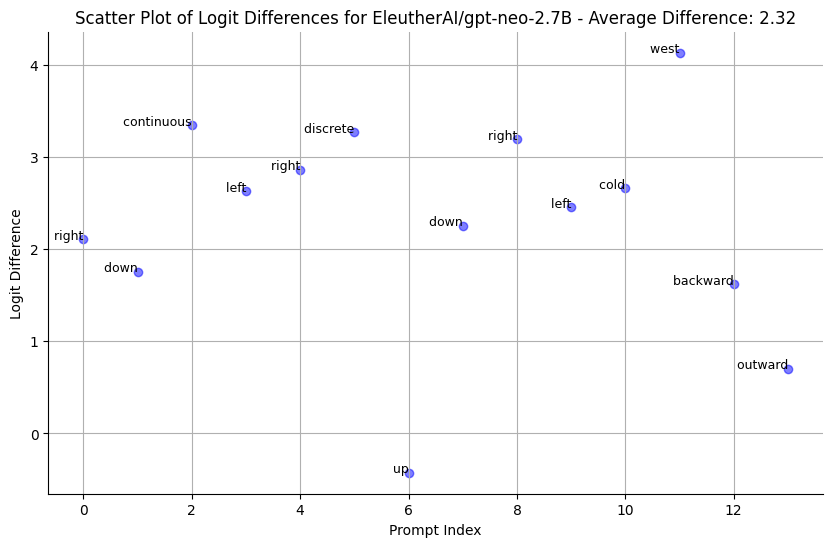

In [32]:
print(
    "Per prompt logit difference:",
    logits_to_avg_logit_diff(original_logits, answer_tokens, per_prompt=True)
    .detach()
    .cpu()
    .round(decimals=3),
)
original_average_logit_diff = logits_to_avg_logit_diff(original_logits, answer_tokens)
print(
    "Average logit difference:",
    round(original_average_logit_diff.item(), 3),
)


# Display prompts, answers, and logits in a side-by-side format with constant spacing
logit_diffs = logits_to_avg_logit_diff(original_logits, answer_tokens, per_prompt=True)
for prompt, answer, logit_diff in zip(prompts, answers, logit_diffs):
    print(
        f"Prompt: {prompt.strip():<70} Answer: {answer.correct:<15} Logit Difference: {logit_diff.item():.2f}"
    )

import matplotlib.pyplot as plt

# Calculate logit differences for each prompt
logit_diffs = (
    logits_to_avg_logit_diff(original_logits, answer_tokens, per_prompt=True)
    .detach()
    .cpu()
    .numpy()
)
# Generate a scatter plot of the logit differences with labels for each point
plt.figure(figsize=(10, 6))
for i, (logit_diff, answer) in enumerate(zip(logit_diffs, answers)):
    _ = plt.scatter(i, logit_diff, color="blue", alpha=0.5)
    _ = plt.text(i, logit_diff, f"{answer.correct}", fontsize=9, ha="right")

# Calculate the average logit difference for the title
average_logit_diff = np.mean(logit_diffs)
plt.title(f"Scatter Plot of Logit Differences for {MODEL_NAME} - Average Difference: {average_logit_diff:.2f}")
plt.xlabel("Prompt Index")
plt.ylabel("Logit Difference")
plt.grid(True)
plt.show()

In [113]:
for prompt, answer in zip(prompts, answers):
    print(utils.test_prompt(prompt, answer.correct, model, prepend_bos=True))

Tokenized prompt: ['<|endoftext|>', '\n', '\n', 'Instead', ' of', ' turning', ' left', ',', ' the', ' character', ' turned']
Tokenized answer: [' right']


Performance on answer token:
Rank: 0        Logit: 17.93 Prob: 61.74% Token: | right|

Top 0th token. Logit: 17.93 Prob: 61.74% Token: | right|
Top 1th token. Logit: 15.94 Prob:  8.49% Token: | left|
Top 2th token. Logit: 15.62 Prob:  6.13% Token: | to|
Top 3th token. Logit: 14.81 Prob:  2.73% Token: | into|
Top 4th token. Logit: 14.54 Prob:  2.08% Token: | the|
Top 5th token. Logit: 14.40 Prob:  1.82% Token: | down|
Top 6th token. Logit: 14.18 Prob:  1.46% Token: | around|
Top 7th token. Logit: 14.11 Prob:  1.36% Token: | up|
Top 8th token. Logit: 13.81 Prob:  1.00% Token: | back|
Top 9th token. Logit: 13.64 Prob:  0.85% Token: | straight|


Ranks of the answer tokens: [(' right', 0)]

TestPromptOutput(correct_rank=0, logit=17.929218292236328, prob=0.617433488368988, answer=' right', answer_str_token=' right')
Tokenized prompt: ['<|endoftext|>', '\n', 'The', ' bird', ' did', ' not', ' fly', ' up', ',', ' it', ' flew']
Tokenized answer: [' down']


Performance on answer token:
Rank: 0        Logit: 17.72 Prob: 43.88% Token: | down|

Top 0th token. Logit: 17.72 Prob: 43.88% Token: | down|
Top 1th token. Logit: 16.15 Prob:  9.09% Token: | up|
Top 2th token. Logit: 15.50 Prob:  4.75% Token: | straight|
Top 3th token. Logit: 15.16 Prob:  3.38% Token: | into|
Top 4th token. Logit: 14.99 Prob:  2.86% Token: | back|
Top 5th token. Logit: 14.97 Prob:  2.80% Token: | away|
Top 6th token. Logit: 14.82 Prob:  2.41% Token: | in|
Top 7th token. Logit: 14.74 Prob:  2.21% Token: | to|
Top 8th token. Logit: 14.63 Prob:  2.00% Token: | out|
Top 9th token. Logit: 14.41 Prob:  1.60% Token: | right|


Ranks of the answer tokens: [(' down', 0)]

TestPromptOutput(correct_rank=0, logit=17.72306251525879, prob=0.4388437867164612, answer=' down', answer_str_token=' down')
Tokenized prompt: ['<|endoftext|>', '\n', '\n', 'The', ' data', ' is', ' not', ' discrete', ',', ' it', ' is']
Tokenized answer: [' continuous']


Performance on answer token:
Rank: 0        Logit: 15.44 Prob: 33.67% Token: | continuous|

Top 0th token. Logit: 15.44 Prob: 33.67% Token: | continuous|
Top 1th token. Logit: 14.43 Prob: 12.30% Token: | a|
Top 2th token. Logit: 13.59 Prob:  5.31% Token: | not|
Top 3th token. Logit: 12.61 Prob:  1.99% Token: | an|
Top 4th token. Logit: 12.44 Prob:  1.68% Token: | in|
Top 5th token. Logit: 12.08 Prob:  1.18% Token: | the|
Top 6th token. Logit: 11.96 Prob:  1.04% Token: | distributed|
Top 7th token. Logit: 11.90 Prob:  0.98% Token: | continuously|
Top 8th token. Logit: 11.84 Prob:  0.92% Token: | discrete|
Top 9th token. Logit: 11.65 Prob:  0.76% Token: | spread|


Ranks of the answer tokens: [(' continuous', 0)]

TestPromptOutput(correct_rank=0, logit=15.43745231628418, prob=0.33673566579818726, answer=' continuous', answer_str_token=' continuous')
Tokenized prompt: ['<|endoftext|>', 'She', ' did', ' not', ' walk', ' towards', ' the', ' right', ',', ' she', ' moved', ' to', ' the']
Tokenized answer: [' left']


Performance on answer token:
Rank: 0        Logit: 17.57 Prob: 79.57% Token: | left|

Top 0th token. Logit: 17.57 Prob: 79.57% Token: | left|
Top 1th token. Logit: 15.53 Prob: 10.40% Token: | right|
Top 2th token. Logit: 13.60 Prob:  1.50% Token: | middle|
Top 3th token. Logit: 12.99 Prob:  0.81% Token: | centre|
Top 4th token. Logit: 12.91 Prob:  0.76% Token: | side|
Top 5th token. Logit: 12.62 Prob:  0.56% Token: | center|
Top 6th token. Logit: 12.26 Prob:  0.40% Token: | other|
Top 7th token. Logit: 12.18 Prob:  0.36% Token: | far|
Top 8th token. Logit: 12.03 Prob:  0.31% Token: | front|
Top 9th token. Logit: 11.75 Prob:  0.24% Token: | very|


Ranks of the answer tokens: [(' left', 0)]

TestPromptOutput(correct_rank=0, logit=17.568321228027344, prob=0.7956908345222473, answer=' left', answer_str_token=' left')
Tokenized prompt: ['<|endoftext|>', 'He', ' did', ' not', ' walk', ' towards', ' the', ' left', ',', ' he', ' moved', ' to', ' the']
Tokenized answer: [' right']


Performance on answer token:
Rank: 0        Logit: 17.00 Prob: 72.94% Token: | right|

Top 0th token. Logit: 17.00 Prob: 72.94% Token: | right|
Top 1th token. Logit: 14.83 Prob:  8.33% Token: | left|
Top 2th token. Logit: 13.83 Prob:  3.09% Token: | centre|
Top 3th token. Logit: 13.71 Prob:  2.73% Token: | middle|
Top 4th token. Logit: 13.13 Prob:  1.53% Token: | center|
Top 5th token. Logit: 12.88 Prob:  1.19% Token: | other|
Top 6th token. Logit: 12.75 Prob:  1.05% Token: | far|
Top 7th token. Logit: 12.05 Prob:  0.52% Token: | extreme|
Top 8th token. Logit: 12.05 Prob:  0.52% Token: | side|
Top 9th token. Logit: 11.91 Prob:  0.45% Token: | very|


Ranks of the answer tokens: [(' right', 0)]

TestPromptOutput(correct_rank=0, logit=16.99580955505371, prob=0.7294237613677979, answer=' right', answer_str_token=' right')
Tokenized prompt: ['<|endoftext|>', '\n', '\n', 'The', ' data', ' is', ' not', ' continuous', ',', ' it', ' is']
Tokenized answer: [' discrete']


Performance on answer token:
Rank: 1        Logit: 13.91 Prob:  8.18% Token: | discrete|

Top 0th token. Logit: 14.48 Prob: 14.50% Token: | a|
Top 1th token. Logit: 13.91 Prob:  8.18% Token: | discrete|
Top 2th token. Logit: 13.49 Prob:  5.37% Token: | not|
Top 3th token. Logit: 12.56 Prob:  2.13% Token: | sampled|
Top 4th token. Logit: 12.41 Prob:  1.82% Token: | only|
Top 5th token. Logit: 12.39 Prob:  1.80% Token: | an|
Top 6th token. Logit: 12.27 Prob:  1.59% Token: | in|
Top 7th token. Logit: 12.16 Prob:  1.42% Token: | categ|
Top 8th token. Logit: 12.06 Prob:  1.29% Token: | binary|
Top 9th token. Logit: 12.03 Prob:  1.25% Token: | missing|


Ranks of the answer tokens: [(' discrete', 1)]

TestPromptOutput(correct_rank=1, logit=13.908510208129883, prob=0.08183404058218002, answer=' discrete', answer_str_token=' discrete')
Tokenized prompt: ['<|endoftext|>', '\n', 'To', ' avoid', ' going', ' down', ',', ' the', ' clim', 'ber', ' went']
Tokenized answer: [' up']


Performance on answer token:
Rank: 0        Logit: 16.98 Prob: 18.76% Token: | up|

Top 0th token. Logit: 16.98 Prob: 18.76% Token: | up|
Top 1th token. Logit: 16.78 Prob: 15.38% Token: | down|
Top 2th token. Logit: 16.52 Prob: 11.91% Token: | to|
Top 3th token. Logit: 16.15 Prob:  8.23% Token: | back|
Top 4th token. Logit: 15.43 Prob:  3.97% Token: | around|
Top 5th token. Logit: 15.35 Prob:  3.68% Token: | on|
Top 6th token. Logit: 15.29 Prob:  3.49% Token: | over|
Top 7th token. Logit: 15.11 Prob:  2.91% Token: | straight|
Top 8th token. Logit: 14.84 Prob:  2.22% Token: | into|
Top 9th token. Logit: 14.56 Prob:  1.67% Token: | through|


Ranks of the answer tokens: [(' up', 0)]

TestPromptOutput(correct_rank=0, logit=16.977611541748047, prob=0.18761871755123138, answer=' up', answer_str_token=' up')
Tokenized prompt: ['<|endoftext|>', '\n', 'To', ' avoid', ' going', ' up', ',', ' the', ' clim', 'ber', ' went']
Tokenized answer: [' down']


Performance on answer token:
Rank: 0        Logit: 18.28 Prob: 48.11% Token: | down|

Top 0th token. Logit: 18.28 Prob: 48.11% Token: | down|
Top 1th token. Logit: 16.60 Prob:  8.97% Token: | back|
Top 2th token. Logit: 16.22 Prob:  6.12% Token: | to|
Top 3th token. Logit: 15.91 Prob:  4.51% Token: | up|
Top 4th token. Logit: 15.85 Prob:  4.23% Token: | around|
Top 5th token. Logit: 15.29 Prob:  2.42% Token: | left|
Top 6th token. Logit: 15.19 Prob:  2.18% Token: | over|
Top 7th token. Logit: 15.06 Prob:  1.92% Token: | straight|
Top 8th token. Logit: 14.96 Prob:  1.73% Token: | right|
Top 9th token. Logit: 14.58 Prob:  1.19% Token: | on|


Ranks of the answer tokens: [(' down', 0)]

TestPromptOutput(correct_rank=0, logit=18.280973434448242, prob=0.4810919463634491, answer=' down', answer_str_token=' down')
Tokenized prompt: ['<|endoftext|>', 'The', ' vehicle', ' couldn', "'t", ' turn', ' left', ',', ' so', ' it', ' turned']
Tokenized answer: [' right']


Performance on answer token:
Rank: 0        Logit: 18.46 Prob: 63.76% Token: | right|

Top 0th token. Logit: 18.46 Prob: 63.76% Token: | right|
Top 1th token. Logit: 15.99 Prob:  5.38% Token: | into|
Top 2th token. Logit: 15.66 Prob:  3.88% Token: | to|
Top 3th token. Logit: 15.40 Prob:  2.99% Token: | around|
Top 4th token. Logit: 15.00 Prob:  2.00% Token: | left|
Top 5th token. Logit: 14.96 Prob:  1.93% Token: | straight|
Top 6th token. Logit: 14.87 Prob:  1.75% Token: | back|
Top 7th token. Logit: 14.75 Prob:  1.55% Token: | in|
Top 8th token. Logit: 14.52 Prob:  1.23% Token: | out|
Top 9th token. Logit: 14.20 Prob:  0.90% Token: | on|


Ranks of the answer tokens: [(' right', 0)]

TestPromptOutput(correct_rank=0, logit=18.463138580322266, prob=0.6376103758811951, answer=' right', answer_str_token=' right')
Tokenized prompt: ['<|endoftext|>', 'The', ' vehicle', ' couldn', "'t", ' turn', ' right', ',', ' so', ' it', ' turned']
Tokenized answer: [' left']


Performance on answer token:
Rank: 0        Logit: 18.55 Prob: 61.63% Token: | left|

Top 0th token. Logit: 18.55 Prob: 61.63% Token: | left|
Top 1th token. Logit: 16.02 Prob:  4.88% Token: | right|
Top 2th token. Logit: 15.88 Prob:  4.27% Token: | into|
Top 3th token. Logit: 15.57 Prob:  3.11% Token: | to|
Top 4th token. Logit: 15.51 Prob:  2.92% Token: | around|
Top 5th token. Logit: 15.02 Prob:  1.80% Token: | in|
Top 6th token. Logit: 14.99 Prob:  1.74% Token: | out|
Top 7th token. Logit: 14.90 Prob:  1.60% Token: | back|
Top 8th token. Logit: 14.55 Prob:  1.12% Token: | on|
Top 9th token. Logit: 14.45 Prob:  1.02% Token: | straight|


Ranks of the answer tokens: [(' left', 0)]

TestPromptOutput(correct_rank=0, logit=18.55448341369629, prob=0.6162826418876648, answer=' left', answer_str_token=' left')
Tokenized prompt: ['<|endoftext|>', 'sy', 'ntax', ' is', ' dual', ' to']
Tokenized answer: [' semantics']


Performance on answer token:
Rank: 43       Logit:  8.75 Prob:  0.23% Token: | semantics|

Top 0th token. Logit: 12.78 Prob: 12.65% Token: | the|
Top 1th token. Logit: 11.84 Prob:  4.96% Token: | that|
Top 2th token. Logit: 11.16 Prob:  2.50% Token: |
|
Top 3th token. Logit: 10.51 Prob:  1.31% Token: | a|
Top 4th token. Logit: 10.47 Prob:  1.26% Token: | C|
Top 5th token. Logit: 10.08 Prob:  0.85% Token: | syntax|
Top 6th token. Logit:  9.86 Prob:  0.68% Token: | c|
Top 7th token. Logit:  9.52 Prob:  0.49% Token: | l|
Top 8th token. Logit:  9.49 Prob:  0.47% Token: |:|
Top 9th token. Logit:  9.43 Prob:  0.44% Token: | python|


Ranks of the answer tokens: [(' semantics', 43)]

TestPromptOutput(correct_rank=43, logit=8.754180908203125, prob=0.0022577072959393263, answer=' semantics', answer_str_token=' semantics')
Tokenized prompt: ['<|endoftext|>', 'sem', 'antics', ' is', ' dual', ' to']
Tokenized answer: [' syntax']


Performance on answer token:
Rank: 2        Logit: 12.92 Prob:  8.82% Token: | syntax|

Top 0th token. Logit: 13.27 Prob: 12.51% Token: | semantics|
Top 1th token. Logit: 13.24 Prob: 12.16% Token: | the|
Top 2th token. Logit: 12.92 Prob:  8.82% Token: | syntax|
Top 3th token. Logit: 11.55 Prob:  2.23% Token: | logic|
Top 4th token. Logit: 11.43 Prob:  1.99% Token: | meaning|
Top 5th token. Logit: 11.40 Prob:  1.92% Token: | prag|
Top 6th token. Logit: 11.16 Prob:  1.52% Token: | that|
Top 7th token. Logit: 11.15 Prob:  1.49% Token: | a|
Top 8th token. Logit: 10.95 Prob:  1.22% Token: |
|
Top 9th token. Logit: 10.71 Prob:  0.97% Token: | synt|


Ranks of the answer tokens: [(' syntax', 2)]

TestPromptOutput(correct_rank=2, logit=12.922626495361328, prob=0.08820965141057968, answer=' syntax', answer_str_token=' syntax')
Tokenized prompt: ['<|endoftext|>', 'he', ' feels', ' hot', ',', ' but', ' i', ' feel']
Tokenized answer: [' cold']


Performance on answer token:
Rank: 0        Logit: 15.55 Prob: 21.66% Token: | cold|

Top 0th token. Logit: 15.55 Prob: 21.66% Token: | cold|
Top 1th token. Logit: 14.98 Prob: 12.30% Token: | like|
Top 2th token. Logit: 13.97 Prob:  4.44% Token: | cool|
Top 3th token. Logit: 13.46 Prob:  2.69% Token: | a|
Top 4th token. Logit: 13.44 Prob:  2.64% Token: | no|
Top 5th token. Logit: 13.27 Prob:  2.21% Token: | good|
Top 6th token. Logit: 13.22 Prob:  2.12% Token: | nothing|
Top 7th token. Logit: 13.22 Prob:  2.10% Token: | hot|
Top 8th token. Logit: 13.21 Prob:  2.08% Token: | fine|
Top 9th token. Logit: 13.08 Prob:  1.83% Token: | so|


Ranks of the answer tokens: [(' cold', 0)]

TestPromptOutput(correct_rank=0, logit=15.549994468688965, prob=0.21660231053829193, answer=' cold', answer_str_token=' cold')
Tokenized prompt: ['<|endoftext|>', '\n', 'The', ' sun', ' did', ' not', ' rise', ' in', ' the', ' east', ',', ' it', ' rose', ' in', ' the']
Tokenized answer: [' west']


Performance on answer token:
Rank: 0        Logit: 17.19 Prob: 82.47% Token: | west|

Top 0th token. Logit: 17.19 Prob: 82.47% Token: | west|
Top 1th token. Logit: 13.94 Prob:  3.19% Token: | West|
Top 2th token. Logit: 13.62 Prob:  2.30% Token: | north|
Top 3th token. Logit: 13.56 Prob:  2.17% Token: | south|
Top 4th token. Logit: 13.06 Prob:  1.33% Token: | east|
Top 5th token. Logit: 12.59 Prob:  0.82% Token: | sky|
Top 6th token. Logit: 11.95 Prob:  0.43% Token: | middle|
Top 7th token. Logit: 11.94 Prob:  0.43% Token: | western|
Top 8th token. Logit: 11.77 Prob:  0.36% Token: |
|
Top 9th token. Logit: 11.07 Prob:  0.18% Token: | southwest|


Ranks of the answer tokens: [(' west', 0)]

TestPromptOutput(correct_rank=0, logit=17.194602966308594, prob=0.8247151970863342, answer=' west', answer_str_token=' west')
Tokenized prompt: ['<|endoftext|>', '\n', '\n', 'The', ' player', ' did', ' not', ' pass', ' the', ' ball', ' forward', ',', ' they', ' passed', ' it']
Tokenized answer: [' backward']


Performance on answer token:
Rank: 1        Logit: 16.42 Prob: 11.43% Token: | backward|

Top 0th token. Logit: 17.42 Prob: 31.32% Token: | backwards|
Top 1th token. Logit: 16.42 Prob: 11.43% Token: | backward|
Top 2th token. Logit: 16.39 Prob: 11.17% Token: | back|
Top 3th token. Logit: 16.38 Prob: 11.02% Token: | to|
Top 4th token. Logit: 16.02 Prob:  7.65% Token: | sideways|
Top 5th token. Logit: 14.80 Prob:  2.26% Token: | forward|
Top 6th token. Logit: 14.26 Prob:  1.33% Token: | on|
Top 7th token. Logit: 14.14 Prob:  1.17% Token: | in|
Top 8th token. Logit: 14.00 Prob:  1.02% Token: | out|
Top 9th token. Logit: 13.99 Prob:  1.01% Token: | around|


Ranks of the answer tokens: [(' backward', 1)]

TestPromptOutput(correct_rank=1, logit=16.416166305541992, prob=0.1142755001783371, answer=' backward', answer_str_token=' backward')
Tokenized prompt: ['<|endoftext|>', '\n', ' The', ' water', ' did', ' not', ' freeze', ',', ' it']
Tokenized answer: [' boiled']


Performance on answer token:
Rank: 9        Logit: 14.73 Prob:  2.57% Token: | boiled|

Top 0th token. Logit: 16.69 Prob: 18.16% Token: | was|
Top 1th token. Logit: 16.05 Prob:  9.62% Token: | froze|
Top 2th token. Logit: 15.75 Prob:  7.11% Token: | simply|
Top 3th token. Logit: 15.17 Prob:  3.99% Token: | merely|
Top 4th token. Logit: 14.97 Prob:  3.27% Token: | turned|
Top 5th token. Logit: 14.96 Prob:  3.22% Token: | just|
Top 6th token. Logit: 14.82 Prob:  2.80% Token: | evapor|
Top 7th token. Logit: 14.78 Prob:  2.70% Token: | became|
Top 8th token. Logit: 14.76 Prob:  2.64% Token: | only|
Top 9th token. Logit: 14.73 Prob:  2.57% Token: | boiled|


Ranks of the answer tokens: [(' boiled', 9)]

TestPromptOutput(correct_rank=9, logit=14.733175277709961, prob=0.025696255266666412, answer=' boiled', answer_str_token=' boiled')
Tokenized prompt: ['<|endoftext|>', '\n', '\n', 'The', ' door', ' didn', "'t", ' open', ' inward', ',', ' it', ' swung']
Tokenized answer: [' outward']


Performance on answer token:
Rank: 1        Logit: 17.75 Prob: 11.58% Token: | outward|

Top 0th token. Logit: 18.97 Prob: 38.92% Token: | open|
Top 1th token. Logit: 17.75 Prob: 11.58% Token: | outward|
Top 2th token. Logit: 17.51 Prob:  9.06% Token: | out|
Top 3th token. Logit: 17.40 Prob:  8.09% Token: | inward|
Top 4th token. Logit: 17.17 Prob:  6.45% Token: | wide|
Top 5th token. Logit: 16.93 Prob:  5.06% Token: | in|
Top 6th token. Logit: 16.29 Prob:  2.69% Token: | back|
Top 7th token. Logit: 15.58 Prob:  1.32% Token: | to|
Top 8th token. Logit: 15.30 Prob:  0.99% Token: | shut|
Top 9th token. Logit: 15.13 Prob:  0.84% Token: | on|


Ranks of the answer tokens: [(' outward', 1)]

TestPromptOutput(correct_rank=1, logit=17.754392623901367, prob=0.11583840847015381, answer=' outward', answer_str_token=' outward')


We see that the average logit difference is 2.3 - for context, this represents putting an $e^{2.3}\approx 10\times$ higher probability on the correct answer.



## Brainstorm What's Actually Going On (Optional)

Before diving into running experiments, it's often useful to spend some time actually reasoning about how the behaviour in question could be implemented in the transformer. **This is optional, and you'll likely get the most out of engaging with this section if you have a decent understanding already of what a transformer is and how it works!**

You don't have to do this and forming hypotheses after exploration is also reasonable, but I think it's often easier to explore and interpret results with some grounding in what you might find. In this particular case, I'm cheating somewhat, since I know the answer, but I'm trying to simulate the process of reasoning about it!

Note that often your hypothesis will be wrong in some ways and often be completely off. We're doing science here, and the goal is to understand how the model *actually* works, and to form true beliefs! There are two separate traps here at two extremes that it's worth tracking:
* Confusion: Having no hypotheses at all, getting a lot of data and not knowing what to do with it, and just floundering around
* Dogmatism: Being overconfident in an incorrect hypothesis and being unwilling to let go of it when reality contradicts you, or flinching away from running the experiments that might disconfirm it.

**Exercise:** Spend some time thinking through how you might imagine this behaviour being implemented in a transformer. Try to think through this for yourself before reading through my thoughts!

<details> <summary>(*) <b>My reasoning</b></summary>

<h3>Brainstorming:</h3>

So, what's hard about the task? Let's focus on the concrete example of the first prompt, "When John and Mary went to the shops, John gave the bag to" -> " Mary".  

A good starting point is thinking though whether a tiny model could do this, eg a <a href="https://transformer-circuits.pub/2021/framework/index.html">1L Attn-Only model</a>. I'm pretty sure the answer is no! Attention is really good at the primitive operations of looking nearby, or copying information. I can believe a tiny model could figure out that at `to` it should look for names and predict that those names came next (eg the skip trigram " John...to -> John"). But it's much harder to tell how <i>many</i> of each previous name there are - attending 0.3 to each copy of John will look exactly the same as attending 0.6 to a single John token. So this will be pretty hard to figure out on the " to" token!

The natural place to break this symmetry is on the second " John" token - telling whether there is an earlier copy of the <i>current</i> token should be a much easier task. So I might expect there to be a head which detects duplicate tokens on the second " John" token, and then another head which moves that information from the second " John" token to the " to" token.

The model then needs to learn to predict " Mary" and <i>not</i> " John". I can see two natural ways to do this:
1. Detect all preceding names and move this information to " to" and then delete the any name corresponding to the duplicate token feature. This feels easier done with a non-linearity, since precisely cancelling out vectors is hard, so I'd imagine an MLP layer deletes the " John" direction of the residual stream
2. Have a head which attends to all previous names, but where the duplicate token features <i>inhibit</i> it from attending to specific names. So this only attends to Mary. And then the output of this head maps to the logits.  

(Spoiler: It's the second one).

<h3>Experiment Ideas</h3>

A test that could distinguish these two is to look at which components of the model add directly to the logits - if it's mostly attention heads which attend to " Mary" and to neither " John" it's probably hypothesis 2, if it's mostly MLPs it's probably hypothesis 1.

And we should be able to identify duplicate token heads by finding ones which attend from " John" to " John", and whose outputs are then moved to the " to" token by V-Composition with another head (Spoiler: It's more complicated than that!)

Note that all of the above reasoning is very simplistic and could easily break in a real model! There'll be significant parts of the model that figure out whether to use this circuit at all (we don't want to inhibit duplicated names when, eg, figuring out what goes at the start of the <i>next</i> sentence), and may be parts towards the end of the model that do "post-processing" just before the final output. But it's a good starting point for thinking about what's going on.

# Brainstorming

## Hypotheses

- [ ] words like 'instead, but..' should trigger somehow
  - [ ] brainstorm visualization
- [ ] 

## Experiments
    - [ ] Test 'instead' etc by deleting word and tracking perf
    - [ ] TODO ask Adam/etc for fancier viz

## Tools/viz

- Each layer's contribution to logit 

In [51]:
# test out prompts with 'clue words' like 'instead' deleted
# hypothesis: replacing these words (with `...`) will wreck perf, idk how i'd do these without those words
elided_prompts_and_answers: list[tuple[str, Answer]] = [
    ("\n\n... of turning left, the character turned", Answer(" right", " left")),
    ("\nThe bird did ... fly up, it flew", Answer(" down", " up")),
    ("\n\nThe data is ... discrete, it is", Answer(" continuous", " discrete")),
    ("She did ... walk towards the right, she moved to the", Answer(" left", " right")),
    ("He did ... walk towards the left, he moved to the", Answer(" right", " left")),
    ("\n\nThe data is ... continuous, it is", Answer(" discrete", " continuous")),
    ("\nTo ... going down, the climber went", Answer(" up", " down")),
    ("\nTo ... going up, the climber went", Answer(" down", " up")),
    ("The vehicle ... turn left, so it turned", Answer(" right", " left")),
    ("The vehicle ... turn right, so it turned", Answer(" left", " right")),
    # ("syntax is ... to", Answer(" semantics", " syntax")),
    # TODO(alok): HACK. it gets the previous one, maybe bc 'syntax and semantics' is a set phrase but 'semantics and syntax' isn't
    # ("semantics is ... to", Answer(" syntax", " semantics")),
    ("he feels hot, ... i feel", Answer(" cold", " hot")),
    ("\nThe sun did ... rise in the east, it rose in the", Answer(" west", " east")),
    (
        "\n\nThe player did ... pass the ball forward, they passed it",
        Answer(" backward", " forward"),
    ),
    # ("\n The water did ... freeze, it", Answer(" boiled", " froze")),
    ("\n\nThe door ... open inward, it swung", Answer(" outward", " inward")),
    # ("\... of accepting the offer, she", Answer(" rejected", " accepted")),  # does poorly here, maybe too open ended?
]


def test_prompts_and_answers(
    prompts_and_answers: list[tuple[str, Answer]], model
) -> None:
    """
    Test the given prompts and answers, plotting the logit differences for each prompt.

    Args:
    prompts_and_answers (list[tuple[str, Answer]]): A list of tuples containing prompts and their corresponding answers.

    Returns:
    plt.Figure: A matplotlib figure showing the logit differences.
    """
    prompts: list[str]
    answers: list[Answer]
    prompts, answers = unzip(prompts_and_answers)

    tokens = model.to_tokens(leftpad(prompts, model), prepend_bos=True)
    original_logits: Float[torch.Tensor, "batch tokens vocab"]
    original_logits, cache = model.run_with_cache(tokens)

    # Convert prompts to tokens and answers to correct and incorrect tokens
    prompt_tokens = [model.to_tokens(prompt) for prompt in prompts]
    answer_tokens = torch.tensor(
        [
            (model.to_single_token(a.correct), model.to_single_token(a.incorrect))
            for a in answers
        ],
        device=device,
    )

    # Display prompts, answers, and logits in a side-by-side format with constant spacing
    logit_diffs = logits_to_avg_logit_diff(
        original_logits, answer_tokens, per_prompt=True
    )
    for prompt, answer, logit_diff in zip(prompts, answers, logit_diffs):
        print(
            f"Prompt: {prompt.strip():<70} Answer: {answer.correct:<15} Logit Difference: {logit_diff.item():.2f}"
        )

    # Calculate logit differences for each prompt
    logit_diffs = (
        logits_to_avg_logit_diff(original_logits, answer_tokens, per_prompt=True)
        .detach()
        .cpu()
        .numpy()
    )
    # Generate a scatter plot of the logit differences with labels for each point using the matplotlib OOP style
    fig, ax = plt.subplots(figsize=(10, 6))
    for i, (logit_diff, answer) in enumerate(zip(logit_diffs, answers)):
        ax.scatter(i, logit_diff, color="blue", alpha=0.5)
        ax.text(i, logit_diff, f"{answer.correct}", fontsize=9, ha="right")

    # Calculate the average logit difference for the title
    average_logit_diff = np.mean(logit_diffs)
    ax.set_title(
        f"Logit Differences for {MODEL_NAME} - Average Difference: {average_logit_diff:.2f}"
    )
    ax.set_xlabel("Prompt Index")
    ax.set_ylabel("Logit Difference")
    ax.grid(True)

    return None

Prompt: ... of turning left, the character turned                              Answer:  right          Logit Difference: 0.38
Prompt: The bird did ... fly up, it flew                                       Answer:  down           Logit Difference: -3.30
Prompt: The data is ... discrete, it is                                        Answer:  continuous     Logit Difference: -3.30
Prompt: She did ... walk towards the right, she moved to the                   Answer:  left           Logit Difference: -0.54
Prompt: He did ... walk towards the left, he moved to the                      Answer:  right          Logit Difference: -0.71
Prompt: The data is ... continuous, it is                                      Answer:  discrete       Logit Difference: -3.02
Prompt: To ... going down, the climber went                                    Answer:  up             Logit Difference: -1.50
Prompt: To ... going up, the climber went                                      Answer:  down           Logit Dif

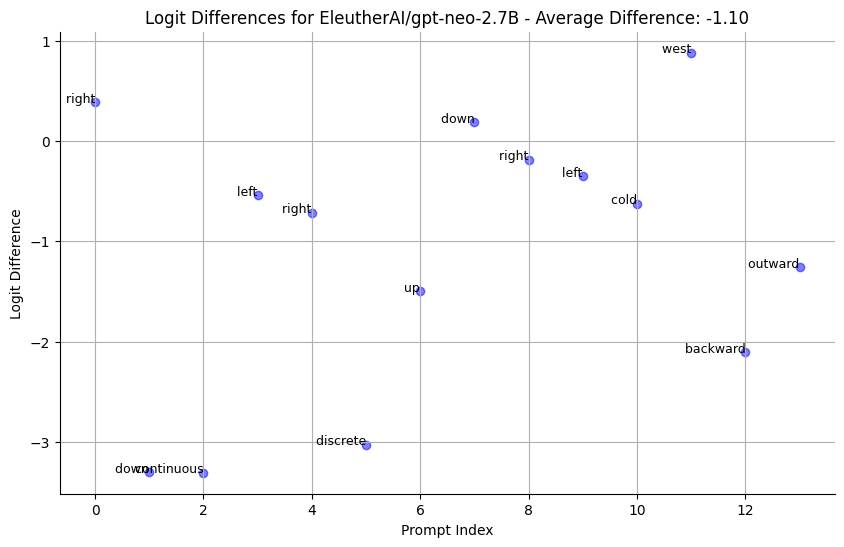

In [52]:
test_prompts_and_answers(elided_prompts_and_answers, model)



Prompt: Instead of turning left, the character turned                          Answer:  right          Logit Difference: 2.11
Prompt: The bird did not fly up, it flew                                       Answer:  down           Logit Difference: 1.75
Prompt: The data is not discrete, it is                                        Answer:  continuous     Logit Difference: 3.34
Prompt: She did not walk towards the right, she moved to the                   Answer:  left           Logit Difference: 2.63
Prompt: He did not walk towards the left, he moved to the                      Answer:  right          Logit Difference: 2.86
Prompt: The data is not continuous, it is                                      Answer:  discrete       Logit Difference: 3.27
Prompt: To avoid going down, the climber went                                  Answer:  up             Logit Difference: -0.43
Prompt: To avoid going up, the climber went                                    Answer:  down           Logit Differen

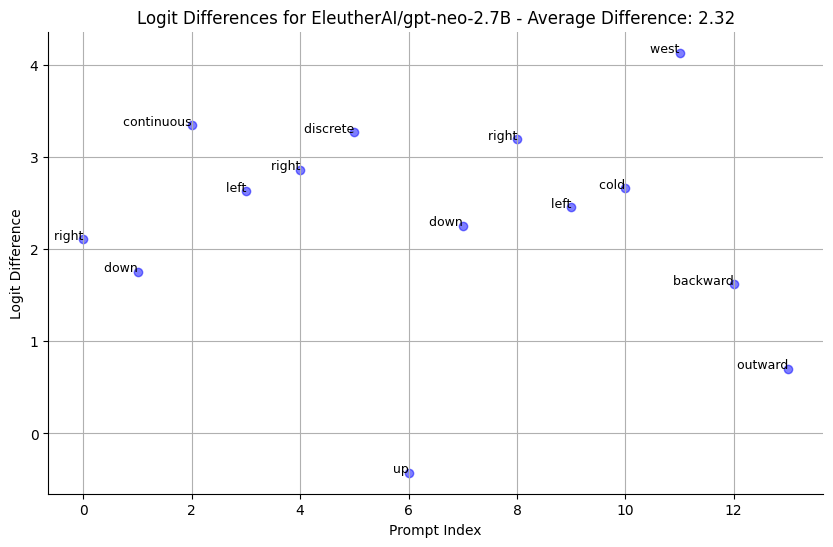

In [53]:
test_prompts_and_answers(prompts_and_answers, model)



## Direct Logit Attribution

*Look up unfamiliar terms in the [mech interp explainer](https://neelnanda.io/glossary)*

Further, the easiest part of the model to understand is the output - this is what the model is trained to optimize, and so it can always be directly interpreted! Often the right approach to reverse engineering a circuit is to start at the end, understand how the model produces the right answer, and to then work backwards. The main technique used to do this is called **direct logit attribution**

**Background:** The central object of a transformer is the **residual stream**. This is the sum of the outputs of each layer and of the original token and positional embedding. Importantly, this means that any linear function of the residual stream can be perfectly decomposed into the contribution of each layer of the transformer. Further, each attention layer's output can be broken down into the sum of the output of each head (See [A Mathematical Framework for Transformer Circuits](https://transformer-circuits.pub/2021/framework/index.html) for details), and each MLP layer's output can be broken down into the sum of the output of each neuron (and a bias term for each layer).

The logits of a model are `logits=Unembed(LayerNorm(final_residual_stream))`. The Unembed is a linear map, and LayerNorm is approximately a linear map, so we can decompose the logits into the sum of the contributions of each component, and look at which components contribute the most to the logit of the correct token! This is called **direct logit attribution**. Here we look at the direct attribution to the logit difference!

<details> <summary>(*) <b>Background and motivation of the logit difference</b></summary>

Logit difference is actually a *really* nice and elegant metric and is a particularly nice aspect of the setup of Indirect Object Identification. In general, there are two natural ways to interpret the model's outputs: the output logits, or the output log probabilities (or probabilities).

The logits are much nicer and easier to understand, as noted above. However, the model is trained to optimize the cross-entropy loss (the average of log probability of the correct token). This means it does not directly optimize the logits, and indeed if the model adds an arbitrary constant to every logit, the log probabilities are unchanged.

But `log_probs == logits.log_softmax(dim=-1) == logits - logsumexp(logits)`, and so `log_probs(" Mary") - log_probs(" John") = logits(" Mary") - logits(" John")` - the ability to add an arbitrary constant cancels out!

Further, the metric helps us isolate the precise capability we care about - figuring out *which* name is the Indirect Object. There are many other components of the task - deciding whether to return an article (the) or pronoun (her) or name, realising that the sentence wants a person next at all, etc. By taking the logit difference we control for all of that.

Our metric is further refined, because each prompt is repeated twice, for each possible indirect object. This controls for irrelevant behaviour such as the model learning that John is a more frequent token than Mary (this actually happens! The final layernorm bias increases the John logit by 1 relative to the Mary logit)

</details>

<details> <summary>Ignoring LayerNorm</summary>

LayerNorm is an analogous normalization technique to BatchNorm (that's friendlier to massive parallelization) that transformers use. Every time a transformer layer reads information from the residual stream, it applies a LayerNorm to normalize the vector at each position (translating to set the mean to 0 and scaling to set the variance to 1) and then applying a learned vector of weights and biases to scale and translate the normalized vector. This is *almost* a linear map, apart from the scaling step, because that divides by the norm of the vector and the norm is not a linear function. (The `fold_ln` flag when loading a model factors out all the linear parts).

But if we fixed the scale factor, the LayerNorm would be fully linear. And the scale of the residual stream is a global property that's a function of *all* components of the stream, while in practice there is normally just a few directions relevant to any particular component, so in practice this is an acceptable approximation. So when doing direct logit attribution we use the `apply_ln` flag on the `cache` to apply the global layernorm scaling factor to each constant. See [my clean GPT-2 implementation](https://colab.research.google.com/github/neelnanda-io/TransformerLens/blob/clean-transformer-demo/Clean_Transformer_Demo.ipynb#scrollTo=Clean_Transformer_Implementation) for more on LayerNorm.
</details>

Getting an output logit is equivalent to projecting onto a direction in the residual stream. We use `model.tokens_to_residual_directions` to map the answer tokens to that direction, and then convert this to a logit difference direction for each batch

In [54]:
answer_residual_directions = model.tokens_to_residual_directions(answer_tokens)
print("Answer residual directions shape:", answer_residual_directions.shape)
logit_diff_directions = (
    answer_residual_directions[:, 0] - answer_residual_directions[:, 1]
)
print("Logit difference directions shape:", logit_diff_directions.shape)

Answer residual directions shape: torch.Size([14, 2, 2560])
Logit difference directions shape: torch.Size([14, 2560])


To verify that this works, we can apply this to the final residual stream for our cached prompts (after applying LayerNorm scaling) and verify that we get the same answer.

<details> <summary>Technical details</summary>

`logits = Unembed(LayerNorm(final_residual_stream))`, so we technically need to account for the centering, and then learned translation and scaling of the layernorm, not just the variance 1 scaling.

The centering is accounted for with the preprocessing flag `center_writing_weights` which ensures that every weight matrix writing to the residual stream has mean zero.

The learned scaling is folded into the unembedding weights `model.unembed.W_U` via `W_U_fold = layer_norm.weights[:, None] * unembed.W_U`

The learned translation is folded to `model.unembed.b_U`, a bias added to the logits (note that GPT-2 is not trained with an existing `b_U`). This roughly represents unigram statistics. But we can ignore this because each prompt occurs twice with names in the opposite order, so this perfectly cancels out.

Note that rather than using layernorm scaling we could just study cache["ln_final.hook_normalised"]

</details>

In [ ]:
# cache syntax - resid_post is the residual stream at the end of the layer, -1 gets the final layer. The general syntax is [activation_name, layer_index, sub_layer_type].
final_residual_stream = cache["resid_post", -1]
print("Final residual stream shape:", final_residual_stream.shape)
final_token_residual_stream = final_residual_stream[:, -1, :]
# Apply LayerNorm scaling
# pos_slice is the subset of the positions we take - here the final token of each prompt
scaled_final_token_residual_stream = cache.apply_ln_to_stack(
    final_token_residual_stream, layer=-1, pos_slice=-1
)

average_logit_diff = einsum(
    "batch d_model, batch d_model -> ",
    scaled_final_token_residual_stream,
    logit_diff_directions,
) / len(prompts)
print("Calculated average logit diff:", round(average_logit_diff.item(), 3))
print("Original logit difference:", round(original_average_logit_diff.item(), 3))

Final residual stream shape: torch.Size([8, 15, 768])
Calculated average logit diff: 3.552
Original logit difference: 3.552


### Logit Lens

We can now decompose the residual stream! First we apply a technique called the [**logit lens**](https://www.alignmentforum.org/posts/AcKRB8wDpdaN6v6ru/interpreting-gpt-the-logit-lens) - this looks at the residual stream after each layer and calculates the logit difference from that. This simulates what happens if we delete all subsequence layers.

In [ ]:
def residual_stack_to_logit_diff(
    residual_stack: Float[torch.Tensor, "components batch d_model"],
    cache: ActivationCache,
) -> float:
    scaled_residual_stack = cache.apply_ln_to_stack(
        residual_stack, layer=-1, pos_slice=-1
    )
    return einsum(
        "... batch d_model, batch d_model -> ...",
        scaled_residual_stack,
        logit_diff_directions,
    ) / len(prompts)

Fascinatingly, we see that the model is utterly unable to do the task until layer 7, almost all performance comes from attention layer 9, and performance actually *decreases* from there.

**Note:** Hover over each data point to see what residual stream position it's from!

<details> <summary>Details on `accumulated_resid`</summary>
**Key:** `n_pre` means the residual stream at the start of layer n, `n_mid` means the residual stream after the attention part of layer n (`n_post` is the same as `n+1_pre` so is not included)

* `layer` is the layer for which we input the residual stream (this is used to identify *which* layer norm scaling factor we want)
* `incl_mid` is whether to include the residual stream in the middle of a layer, ie after attention & before MLP
* `pos_slice` is the subset of the positions used. See `utils.Slice` for details on the syntax.
* return_labels is whether to return the labels for each component returned (useful for plotting)
</details>

In [ ]:
accumulated_residual, labels = cache.accumulated_resid(
    layer=-1, incl_mid=True, pos_slice=-1, return_labels=True
)
logit_lens_logit_diffs = residual_stack_to_logit_diff(accumulated_residual, cache)
line(
    logit_lens_logit_diffs,
    x=np.arange(model.cfg.n_layers * 2 + 1) / 2,
    hover_name=labels,
    title="Logit Difference From Accumulate Residual Stream",
)

### Layer Attribution

We can repeat the above analysis but for each layer (this is equivalent to the differences between adjacent residual streams)

Note: Annoying terminology overload - layer k of a transformer means the kth **transformer block**, but each block consists of an **attention layer** (to move information around) *and* an **MLP layer** (to process information).

We see that only attention layers matter, which makes sense! The IOI task is about moving information around (ie moving the correct name and not the incorrect name), and less about processing it. And again we note that attention layer 9 improves things a lot, while attention 10 and attention 11 *decrease* performance

In [ ]:
per_layer_residual, labels = cache.decompose_resid(
    layer=-1, pos_slice=-1, return_labels=True
)
per_layer_logit_diffs = residual_stack_to_logit_diff(per_layer_residual, cache)
line(per_layer_logit_diffs, hover_name=labels, title="Logit Difference From Each Layer")

## Head Attribution

We can further break down the output of each attention layer into the sum of the outputs of each attention head. Each attention layer consists of 12 heads, which each act independently and additively.

<details> <summary>Decomposing attention output into sums of heads</summary>
The standard way to compute the output of an attention layer is by concatenating the mixed values of each head, and multiplying by a big output weight matrix. But as described in [A Mathematical Framework](https://transformer-circuits.pub/2021/framework/index.html) this is equivalent to splitting the output weight matrix into a per-head output (here `model.blocks[k].attn.W_O`) and adding them up (including an overall bias term for the entire layer)
</details>

We see that only a few heads really matter - heads L9H6 and L9H9 contribute a lot positively (explaining why attention layer 9 is so important), while heads L10H7 and L11H10 contribute a lot negatively (explaining why attention layer 10 and layer 11 are actively harmful). These correspond to (some of) the name movers and negative name movers discussed in the paper. There are also several heads that matter positively or negatively but less strongly (other name movers and backup name movers)

There are a few meta observations worth making here - our model has 144 heads, yet we could localise this behaviour to a handful of specific heads, using straightforward, general techniques. This supports the claim in [A Mathematical Framework](https://transformer-circuits.pub/2021/framework/index.html) that attention heads are the right level of abstraction to understand attention. It also really surprising that there are *negative* heads - eg L10H7 makes the incorrect logit 7x *more* likely. I'm not sure what's going on there, though the paper discusses some possibilities.

In [ ]:
per_head_residual, labels = cache.stack_head_results(
    layer=-1, pos_slice=-1, return_labels=True
)
per_head_logit_diffs = residual_stack_to_logit_diff(per_head_residual, cache)
per_head_logit_diffs = einops.rearrange(
    per_head_logit_diffs,
    "(layer head_index) -> layer head_index",
    layer=model.cfg.n_layers,
    head_index=model.cfg.n_heads,
)
imshow(
    per_head_logit_diffs,
    labels={"x": "Head", "y": "Layer"},
    title="Logit Difference From Each Head",
)

Tried to stack head results when they weren't cached. Computing head results now


## Attention Analysis

Attention heads are particularly easy to study because we can look directly at their attention patterns and study from what positions they move information from and two. This is particularly easy here as we're looking at the direct effect on the logits so we need only look at the attention patterns from the final token.

We use Alan Cooney's circuitsvis library to visualize the attention patterns! We visualize the top 3 positive and negative heads by direct logit attribution, and show these for the first prompt (as an illustration).

<details> <summary>Interpreting Attention Patterns</summary>
An easy mistake to make when looking at attention patterns is thinking that they must convey information about the <i>token</i> looked at (maybe accounting for the context of the token). But actually, all we can confidently say is that it moves information from the *residual stream position* corresponding to that input token. Especially later on in the model, there may be components in the residual stream that are nothing to do with the input token! Eg the period at the end of a sentence may contain summary information for that sentence, and the head may solely move that, rather than caring about whether it ends in ".", "!" or "?"
</details>

In [ ]:
def visualize_attention_patterns(
    heads: Union[List[int], int, Float[torch.Tensor, "heads"]],
    local_cache: ActivationCache,
    local_tokens: torch.Tensor,
    title: Optional[str] = "",
    max_width: Optional[int] = 700,
) -> str:
    # If a single head is given, convert to a list
    if isinstance(heads, int):
        heads = [heads]

    # Create the plotting data
    labels: List[str] = []
    patterns: List[Float[torch.Tensor, "dest_pos src_pos"]] = []

    # Assume we have a single batch item
    batch_index = 0

    for head in heads:
        # Set the label
        layer = head // model.cfg.n_heads
        head_index = head % model.cfg.n_heads
        labels.append(f"L{layer}H{head_index}")

        # Get the attention patterns for the head
        # Attention patterns have shape [batch, head_index, query_pos, key_pos]
        patterns.append(local_cache["attn", layer][batch_index, head_index])

    # Convert the tokens to strings (for the axis labels)
    str_tokens = model.to_str_tokens(local_tokens)

    # Combine the patterns into a single tensor
    patterns: Float[torch.Tensor, "head_index dest_pos src_pos"] = torch.stack(
        patterns, dim=0
    )

    # Circuitsvis Plot (note we get the code version so we can concatenate with the title)
    plot = attention_heads(
        attention=patterns, tokens=str_tokens, attention_head_names=labels
    ).show_code()

    # Display the title
    title_html = f"<h2>{title}</h2><br/>"

    # Return the visualisation as raw code
    return f"<div style='max-width: {str(max_width)}px;'>{title_html + plot}</div>"

Inspecting the patterns, we can see that both types of name movers attend to the indirect object - this suggests they're simply copying the name attended to (with the OV circuit) and that the interesting part is the circuit behind the attention pattern that calculates *where* to move information from (the QK circuit)

In [ ]:
top_k = 3

top_positive_logit_attr_heads = torch.topk(
    per_head_logit_diffs.flatten(), k=top_k
).indices

positive_html = visualize_attention_patterns(
    top_positive_logit_attr_heads,
    cache,
    tokens[0],
    f"Top {top_k} Positive Logit Attribution Heads",
)

top_negative_logit_attr_heads = torch.topk(
    -per_head_logit_diffs.flatten(), k=top_k
).indices

negative_html = visualize_attention_patterns(
    top_negative_logit_attr_heads,
    cache,
    tokens[0],
    title=f"Top {top_k} Negative Logit Attribution Heads",
)

HTML(positive_html + negative_html)

## Activation Patching

**This section explains how to do activation patching conceptually by implementing it from scratch. To use it in practice with TransformerLens, see [this demonstration instead](https://colab.research.google.com/github/neelnanda-io/TransformerLens/blob/main/demos/Activation_Patching_in_TL_Demo.ipynb)**.

The obvious limitation to the techniques used above is that they only look at the very end of the circuit - the parts that directly affect the logits. Clearly this is not sufficient to understand the circuit! We want to understand how things compose together to produce this final output, and ideally to produce an end-to-end circuit fully explaining this behaviour.

The technique we'll use to investigate this is called **activation patching**. This was first introduced in [David Bau and Kevin Meng's excellent ROME paper](https://rome.baulab.info/), there called causal tracing.

The setup of activation patching is to take two runs of the model on two different inputs, the clean run and the corrupted run. The clean run outputs the correct answer and the corrupted run does not. The key idea is that we give the model the corrupted input, but then **intervene** on a specific activation and **patch** in the corresponding activation from the clean run (ie replace the corrupted activation with the clean activation), and then continue the run. And we then measure how much the output has updated towards the correct answer.

We can then iterate over many possible activations and look at how much they affect the corrupted run. If patching in an activation significantly increases the probability of the correct answer, this allows us to *localise* which activations matter.

The ability to localise is a key move in mechanistic interpretability - if the computation is diffuse and spread across the entire model, it is likely much harder to form a clean mechanistic story for what's going on. But if we can identify precisely which parts of the model matter, we can then zoom in and determine what they represent and how they connect up with each other, and ultimately reverse engineer the underlying circuit that they represent.

Here's an animation from the ROME paper demonstrating this technique (they studied factual recall, and use stars to represent corruption applied to the subject of the sentence, but the same principles apply):

![CT Animation](https://rome.baulab.info/images/small-ct-animation.gif)

See also [the explanation in a mech interp explainer](https://dynalist.io/d/n2ZWtnoYHrU1s4vnFSAQ519J#z=qeWBvs-R-taFfcCq-S_hgMqx) and [this piece](https://www.neelnanda.io/mechanistic-interpretability/attribution-patching#how-to-think-about-activation-patching) describing how to think about patching on a conceptual level

The above was all fairly abstract, so let's zoom in and lay out a concrete example to understand Indirect Object Identification.

Here our clean input will be eg "After John and Mary went to the store, **John** gave a bottle of milk to" and our corrupted input will be eg "After John and Mary went to the store, **Mary** gave a bottle of milk to". These prompts are identical except for the name of the indirect object, and so patching is a causal intervention which will allow us to understand precisely which parts of the network are identifying the indirect object.

One natural thing to patch in is the residual stream at a specific layer and specific position. For example, the model is likely initially doing some processing on the second subject token to realise that it's a duplicate, but then uses attention to move that information to the " to" token. So patching in the residual stream at the " to" token will likely matter a lot in later layers but not at all in early layers.

We can zoom in much further and patch in specific activations from specific layers. For example, we think that the output of head L9H9 on the final token is significant for directly connecting to the logits

We can patch in specific activations, and can zoom in as far as seems reasonable. For example, if we patch in the output of head L9H9 on the final token, we would predict that it will significantly affect performance.

Note that this technique does *not* tell us how the components of the circuit connect up, just what they are.

<details> <summary>Technical details</summary>
The choice of clean and corrupted prompt has both pros and cons. By carefully setting up the counterfactual, that <i>only</i> differs in the second subject, we avoid detecting the parts of the model doing irrelevant computation like detecting that the indirect object task is relevant at all or that it should be outputting a name rather than an article or pronoun. Or even context like that John and Mary are names at all.

However, it *also* bakes in some details that *are* relevant to the task. Such as finding the location of the second subject, and of the names in the first clause. Or that the name mover heads have learned to copy whatever they look at.

Some of these could be patched by also changing up the order of the names in the original sentence - patching in "After <b>John and Mary</b> went to the store, John gave a bottle of milk to" vs "After <b>Mary and John</b> went to the store, John gave a bottle of milk to".

In the ROME paper they take a different tack. Rather than carefully setting up counterfactuals between two different but related inputs, they **corrupt** the clean input by adding Gaussian noise to the token embedding for the subject. This is in some ways much lower effort (you don't need to set up a similar but different prompt) but can also introduce some issues, such as ways this noise might break things. In practice, you should take care about how you choose your counterfactuals and try out several. Try to reason beforehand about what they will and will not tell you, and compare the results between different counterfactuals.

I discuss some of these limitations and how the author's solved them with much more refined usage of these techniques <a href="https://www.youtube.com/watch?v=gzwj0jWbvbo">in our interview</a>
</details>

## Residual Stream

Lets begin by patching in the residual stream at the start of each layer and for each token position.

We first create a set of corrupted tokens - where we swap each pair of prompts to have the opposite answer.

In [ ]:
corrupted_prompts = []
for i in range(0, len(prompts), 2):
    corrupted_prompts.append(prompts[i + 1])
    corrupted_prompts.append(prompts[i])
corrupted_tokens = model.to_tokens(corrupted_prompts, prepend_bos=True)
corrupted_logits, corrupted_cache = model.run_with_cache(
    corrupted_tokens, return_type="logits"
)
corrupted_average_logit_diff = logits_to_avg_logit_diff(corrupted_logits, answer_tokens)
print("Corrupted Average Logit Diff", round(corrupted_average_logit_diff.item(), 2))
print("Clean Average Logit Diff", round(original_average_logit_diff.item(), 2))

Corrupted Average Logit Diff -3.55
Clean Average Logit Diff 3.55


In [1]:
model.to_string(corrupted_tokens)

NameError: name 'model' is not defined

We now intervene on the corrupted run and patch in the clean residual stream at a specific layer and position.

We do the intervention using TransformerLens's `HookPoint` feature. We can design a hook function that takes in a specific activation and returns an edited copy, and temporarily add it in with `model.run_with_hooks`.

In [ ]:
def patch_residual_component(
    corrupted_residual_component: Float[torch.Tensor, "batch pos d_model"],
    hook,
    pos,
    clean_cache,
):
    corrupted_residual_component[:, pos, :] = clean_cache[hook.name][:, pos, :]
    return corrupted_residual_component


def normalize_patched_logit_diff(patched_logit_diff):
    # Subtract corrupted logit diff to measure the improvement, divide by the total improvement from clean to corrupted to normalise
    # 0 means zero change, negative means actively made worse, 1 means totally recovered clean performance, >1 means actively *improved* on clean performance
    return (patched_logit_diff - corrupted_average_logit_diff) / (
        original_average_logit_diff - corrupted_average_logit_diff
    )


patched_residual_stream_diff = torch.zeros(
    model.cfg.n_layers, tokens.shape[1], device=device, dtype=torch.float32
)
for layer in range(model.cfg.n_layers):
    for position in range(tokens.shape[1]):
        hook_fn = partial(patch_residual_component, pos=position, clean_cache=cache)
        patched_logits = model.run_with_hooks(
            corrupted_tokens,
            fwd_hooks=[(utils.get_act_name("resid_pre", layer), hook_fn)],
            return_type="logits",
        )
        patched_logit_diff = logits_to_avg_logit_diff(patched_logits, answer_tokens)

        patched_residual_stream_diff[layer, position] = normalize_patched_logit_diff(
            patched_logit_diff
        )

We can immediately see that, exactly as predicted, originally all relevant computation happens on the second subject token, and at layers 7 and 8, the information is moved to the final token. Moving the residual stream at the correct position near *exactly* recovers performance!

For reference, tokens and their index from the first prompt are on the x-axis. In an abuse of notation, note that the difference here is averaged over *all* 8 prompts, while the labels only come from the *first* prompt.

To be easier to interpret, we normalise the logit difference, by subtracting the corrupted logit difference, and dividing by the total improvement from clean to corrupted to normalise
0 means zero change, negative means actively made worse, 1 means totally recovered clean performance, >1 means actively *improved* on clean performance

In [ ]:
prompt_position_labels = [
    f"{tok}_{i}" for i, tok in enumerate(model.to_str_tokens(tokens[0]))
]
imshow(
    patched_residual_stream_diff,
    x=prompt_position_labels,
    title="Logit Difference From Patched Residual Stream",
    labels={"x": "Position", "y": "Layer"},
)

## Layers

We can apply exactly the same idea, but this time patching in attention or MLP layers. These are also residual components with identical shapes to the residual stream terms, so we can reuse the same hooks.

In [ ]:
patched_attn_diff = torch.zeros(
    model.cfg.n_layers, tokens.shape[1], device=device, dtype=torch.float32
)
patched_mlp_diff = torch.zeros(
    model.cfg.n_layers, tokens.shape[1], device=device, dtype=torch.float32
)
for layer in range(model.cfg.n_layers):
    for position in range(tokens.shape[1]):
        hook_fn = partial(patch_residual_component, pos=position, clean_cache=cache)
        patched_attn_logits = model.run_with_hooks(
            corrupted_tokens,
            fwd_hooks=[(utils.get_act_name("attn_out", layer), hook_fn)],
            return_type="logits",
        )
        patched_attn_logit_diff = logits_to_avg_logit_diff(
            patched_attn_logits, answer_tokens
        )
        patched_mlp_logits = model.run_with_hooks(
            corrupted_tokens,
            fwd_hooks=[(utils.get_act_name("mlp_out", layer), hook_fn)],
            return_type="logits",
        )
        patched_mlp_logit_diff = logits_to_avg_logit_diff(
            patched_mlp_logits, answer_tokens
        )

        patched_attn_diff[layer, position] = normalize_patched_logit_diff(
            patched_attn_logit_diff
        )
        patched_mlp_diff[layer, position] = normalize_patched_logit_diff(
            patched_mlp_logit_diff
        )

We see that several attention layers are significant but that, matching the residual stream results, early layers matter on the second subject token, and later layers matter on the final token, and layers essentially don't matter on any other token. Extremely localised! As with direct logit attribution, layer 9 is positive and layers 10 and 11 are not, suggesting that the late layers only matter for direct logit effects, but we also see that layers 7 and 8 matter significantly. Presumably these are the heads that move information about which name is duplicated from the second subject token to the final token.

In [ ]:
imshow(
    patched_attn_diff,
    x=prompt_position_labels,
    title="Logit Difference From Patched Attention Layer",
    labels={"x": "Position", "y": "Layer"},
)

In contrast, the MLP layers do not matter much. This makes sense, since this is more a task about moving information than about processing it, and the MLP layers specialise in processing information.

The one exception is MLP 0, which matters a lot, but I think this is misleading and just a generally true statement about MLP 0 rather than being about the circuit on this task.

<details> <summary>My takes on MLP0</summary>
It's often observed on GPT-2 Small that MLP0 matters a lot, and that ablating it utterly destroys performance. My current best guess is that the first MLP layer is essentially acting as an extension of the embedding (for whatever reason) and that when later layers want to access the input tokens they mostly read in the output of the first MLP layer, rather than the token embeddings. Within this frame, the first attention layer doesn't do much.

In this framing, it makes sense that MLP0 matters on the second subject token, because that's the one position with a different input token!

I'm not entirely sure why this happens, but I would guess that it's because the embedding and unembedding matrices in GPT-2 Small are the same. This is pretty unprincipled, as the tasks of embedding and unembedding tokens are <i>not</i> inverses, but this is common practice, and plausibly models want to dedicate some parameters to overcoming this.

I only have suggestive evidence of this, and would love to see someone look into this properly!
</details>

In [ ]:
imshow(
    patched_mlp_diff,
    x=prompt_position_labels,
    title="Logit Difference From Patched MLP Layer",
    labels={"x": "Position", "y": "Layer"},
)

## Heads

We can refine the above analysis by patching in individual heads! This is somewhat more annoying, because there are now three dimensions (head_index, position and layer), so for now lets patch in a head's output across all positions.

The easiest way to do this is to patch in the activation `z`, the "mixed value" of the attention head. That is, the average of all previous values weighted by the attention pattern, ie the activation that is then multiplied by `W_O`, the output weights.

In [ ]:
def patch_head_vector(
    corrupted_head_vector: Float[torch.Tensor, "batch pos head_index d_head"],
    hook,
    head_index,
    clean_cache,
):
    corrupted_head_vector[:, :, head_index, :] = clean_cache[hook.name][
        :, :, head_index, :
    ]
    return corrupted_head_vector


patched_head_z_diff = torch.zeros(
    model.cfg.n_layers, model.cfg.n_heads, device=device, dtype=torch.float32
)
for layer in range(model.cfg.n_layers):
    for head_index in range(model.cfg.n_heads):
        hook_fn = partial(patch_head_vector, head_index=head_index, clean_cache=cache)
        patched_logits = model.run_with_hooks(
            corrupted_tokens,
            fwd_hooks=[(utils.get_act_name("z", layer, "attn"), hook_fn)],
            return_type="logits",
        )
        patched_logit_diff = logits_to_avg_logit_diff(patched_logits, answer_tokens)

        patched_head_z_diff[layer, head_index] = normalize_patched_logit_diff(
            patched_logit_diff
        )

We can now see that, in addition to the name mover heads identified before, in mid-late layers the heads L8H6, L8H10, L7H9 matter and are presumably responsible for moving information from the second subject to the final token. And heads L5H5, L6H9, L3H0 also matter a lot, and are presumably involved in detecting duplicated tokens.

In [ ]:
imshow(
    patched_head_z_diff,
    title="Logit Difference From Patched Head Output",
    labels={"x": "Head", "y": "Layer"},
)

## Decomposing Heads

Decomposing attention layers into patching in individual heads has already helped us localise the behaviour a lot. But we can understand it further by decomposing heads. An attention head consists of two semi-independent operations - calculating *where* to move information from and to (represented by the attention pattern and implemented via the QK-circuit) and calculating *what* information to move (represented by the value vectors and implemented by the OV circuit). We can disentangle which of these is important by patching in just the attention pattern *or* the value vectors. (See [A Mathematical Framework](https://transformer-circuits.pub/2021/framework/index.html) or [my walkthrough video](https://www.youtube.com/watch?v=KV5gbOmHbjU) for more on this decomposition. If you're not familiar with the details of how attention is implemented, I recommend checking out [my clean transformer implementation](https://colab.research.google.com/github/neelnanda-io/TransformerLens/blob/clean-transformer-demo/Clean_Transformer_Demo.ipynb#scrollTo=3Pb0NYbZ900e) to see how the code works))

First let's patch in the value vectors, to measure when figuring out what to move is important. . This has the same shape as z ([batch, pos, head_index, d_head]) so we can reuse the same hook.

In [ ]:
patched_head_v_diff = torch.zeros(
    model.cfg.n_layers, model.cfg.n_heads, device=device, dtype=torch.float32
)
for layer in range(model.cfg.n_layers):
    for head_index in range(model.cfg.n_heads):
        hook_fn = partial(patch_head_vector, head_index=head_index, clean_cache=cache)
        patched_logits = model.run_with_hooks(
            corrupted_tokens,
            fwd_hooks=[(utils.get_act_name("v", layer, "attn"), hook_fn)],
            return_type="logits",
        )
        patched_logit_diff = logits_to_avg_logit_diff(patched_logits, answer_tokens)

        patched_head_v_diff[layer, head_index] = normalize_patched_logit_diff(
            patched_logit_diff
        )

We can plot this as a heatmap and it's initially hard to interpret.

In [ ]:
imshow(
    patched_head_v_diff,
    title="Logit Difference From Patched Head Value",
    labels={"x": "Head", "y": "Layer"},
)

But it's very easy to interpret if we plot a scatter plot against patching head outputs. Here we see that the earlier heads (L5H5, L6H9, L3H0) and late name movers (L9H9, L10H7, L11H10) don't matter at all now, while the mid-late heads (L8H6, L8H10, L7H9) do.

Meta lesson: Plot things early, often and in diverse ways as you explore a model's internals!

In [ ]:
head_labels = [
    f"L{l}H{h}" for l in range(model.cfg.n_layers) for h in range(model.cfg.n_heads)
]
scatter(
    x=utils.to_numpy(patched_head_v_diff.flatten()),
    y=utils.to_numpy(patched_head_z_diff.flatten()),
    xaxis="Value Patch",
    yaxis="Output Patch",
    caxis="Layer",
    hover_name=head_labels,
    color=einops.repeat(
        np.arange(model.cfg.n_layers), "layer -> (layer head)", head=model.cfg.n_heads
    ),
    range_x=(-0.5, 0.5),
    range_y=(-0.5, 0.5),
    title="Scatter plot of output patching vs value patching",
)

When we patch in attention patterns, we see the opposite effect - early and late heads matter a lot, middle heads don't. (In fact, the sum of value patching and pattern patching is approx the same as output patching)

In [ ]:
def patch_head_pattern(
    corrupted_head_pattern: Float[torch.Tensor, "batch head_index query_pos d_head"],
    hook,
    head_index,
    clean_cache,
):
    corrupted_head_pattern[:, head_index, :, :] = clean_cache[hook.name][
        :, head_index, :, :
    ]
    return corrupted_head_pattern


patched_head_attn_diff = torch.zeros(
    model.cfg.n_layers, model.cfg.n_heads, device=device, dtype=torch.float32
)
for layer in range(model.cfg.n_layers):
    for head_index in range(model.cfg.n_heads):
        hook_fn = partial(patch_head_pattern, head_index=head_index, clean_cache=cache)
        patched_logits = model.run_with_hooks(
            corrupted_tokens,
            fwd_hooks=[(utils.get_act_name("attn", layer, "attn"), hook_fn)],
            return_type="logits",
        )
        patched_logit_diff = logits_to_avg_logit_diff(patched_logits, answer_tokens)

        patched_head_attn_diff[layer, head_index] = normalize_patched_logit_diff(
            patched_logit_diff
        )

In [ ]:
imshow(
    patched_head_attn_diff,
    title="Logit Difference From Patched Head Pattern",
    labels={"x": "Head", "y": "Layer"},
)
head_labels = [
    f"L{l}H{h}" for l in range(model.cfg.n_layers) for h in range(model.cfg.n_heads)
]
scatter(
    x=utils.to_numpy(patched_head_attn_diff.flatten()),
    y=utils.to_numpy(patched_head_z_diff.flatten()),
    hover_name=head_labels,
    xaxis="Attention Patch",
    yaxis="Output Patch",
    title="Scatter plot of output patching vs attention patching",
)

## Consolidating Understanding

OK, let's zoom out and reconsolidate. At a high-level, we find that all the action is on the second subject token until layer 7 and then transitions to the final token. And that attention layers matter a lot, MLP layers not so much (apart from MLP0, likely as an extended embedding).

We've further localised important behaviour to several categories of heads. We've found 3 categories of heads that matter a lot - early heads (L5H5, L6H9, L3H0) whose output matters on the second subject and whose behaviour is determined by their attention patterns, mid-late heads (L8H6, L8H10, L7H9, L7H3) whose output matters on the final token and whose behaviour is determined by their value vectors, and late heads (L9H9, L10H7, L11H10) whose output matters on the final token and whose behaviour is determined by their attention patterns.

A natural speculation is that early heads detect both that the second subject is a repeated token and *which* is repeated (ie the " John" token is repeated), middle heads compose with this and move this duplicated token information from the second subject token to the final token, and the late heads compose with this to *inhibit* their attention to the duplicated token, and then attend to the correct indirect object name and copy that directly to the logits.

### Visualizing Attention Patterns

We can validate this by looking at the attention patterns of these heads! Let's take the top 10 heads by output patching (in absolute value) and split it into early, middle and late.

We see that middle heads attend from the final token to the second subject, and late heads attend from the final token to the indirect object, which is completely consistent with the above speculation! But weirdly, while *one* early head attends from the second subject to its first copy, the other two mysteriously attend to the word *after* the first copy.

In [ ]:
top_k = 10
top_heads_by_output_patch = torch.topk(
    patched_head_z_diff.abs().flatten(), k=top_k
).indices
first_mid_layer = 7
first_late_layer = 9
early_heads = top_heads_by_output_patch[
    top_heads_by_output_patch < model.cfg.n_heads * first_mid_layer
]
mid_heads = top_heads_by_output_patch[
    torch.logical_and(
        model.cfg.n_heads * first_mid_layer <= top_heads_by_output_patch,
        top_heads_by_output_patch < model.cfg.n_heads * first_late_layer,
    )
]
late_heads = top_heads_by_output_patch[
    model.cfg.n_heads * first_late_layer <= top_heads_by_output_patch
]

early = visualize_attention_patterns(
    early_heads, cache, tokens[0], title=f"Top Early Heads"
)
mid = visualize_attention_patterns(
    mid_heads, cache, tokens[0], title=f"Top Middle Heads"
)
late = visualize_attention_patterns(
    late_heads, cache, tokens[0], title=f"Top Late Heads"
)

HTML(early + mid + late)

### Comparing to the Paper

We can now refer to the (far, far more rigorous and detailed) analysis in the paper to compare our results! Here's the diagram they give of their results.

![IOI1](https://pbs.twimg.com/media/FghGkTAWAAAmkhm.jpg)

(Head 1.2 in their notation is L1H2 in my notation etc. And note - in the [latest version of the paper](https://arxiv.org/pdf/2211.00593.pdf) they add 9.0 as a backup name mover, and remove 11.3)

The heads form three categories corresponding to the early, middle and late categories we found and we did fairly well! Definitely not perfect, but with some fairly generic techniques and some a priori reasoning, we found the broad strokes of the circuit and what it looks like. We focused on the most important heads, so we didn't find all relevant heads in each category (especially not the heads in brackets, which are more minor), but this serves as a good base for doing more rigorous and involved analysis, especially for finding the *complete* circuit (ie all of the parts of the model which participate in this behaviour) rather than just a partial and suggestive circuit. Go check out [their paper](https://arxiv.org/abs/2211.00593) or [our interview](https://www.youtube.com/watch?v=gzwj0jWbvbo) to learn more about what they did and what they found!

Breaking down their categories:

* Early: The duplicate token heads, previous token heads and induction heads. These serve the purpose of detecting that the second subject is duplicated and which earlier name is the duplicate.
    * We found a direct duplicate token head which behaves exactly as expected, L3H0. Heads L5H0 and L6H9 are induction heads, which explains why they don't attend directly to the earlier copy of John!
    * Note that the duplicate token heads and induction heads do not compose with each other - both directly add to the S-Inhibition heads. The diagram is somewhat misleading.
* Middle: They call these S-Inhibition heads - they copy the information about the duplicate token from the second subject to the to token, and their output is used to *inhibit* the attention paid from the name movers to the first subject copy. We found all these heads, and had a decent guess for what they did.
    * In either case they attend to the second subject, so the patch that mattered was their value vectors!
* Late: They call these name movers, and we found some of them. They attend from the final token to the indirect object name and copy that to the logits, using the S-Inhibition heads to inhibit attention to the first copy of the subject token.
    * We did find their surprising result of *negative* name movers - name movers that inhibit the correct answer!
    * They have an entire category of heads we missed called backup name movers - we'll get to these later.

So, now, let's dig into the two anomalies we missed - induction heads and backup name mover heads

## Bonus: Exploring Anomalies

### Early Heads are Induction Heads(?!)

A really weird observation is that some of the early heads detecting duplicated tokens are induction heads, not just direct duplicate token heads. This is very weird! What's up with that?

First off, what's an induction head? An induction head is an important type of attention head that can detect and continue repeated sequences. It is the second head in a two head induction circuit, which looks for previous copies of the current token and attends to the token *after* it, and then copies that to the current position and predicts that it will come next. They're enough of a big deal that [we wrote a whole paper on them](https://transformer-circuits.pub/2022/in-context-learning-and-induction-heads/index.html).

![Move image demo](https://pbs.twimg.com/media/FNWAzXjVEAEOGRe.jpg)

Second, why is it surprising that they come up here? It's surprising because it feels like overkill. The model doesn't care about *what* token comes after the first copy of the subject, just that it's duplicated. And it already has simpler duplicate token heads. My best guess is that it just already had induction heads around and that, in addition to their main function, they *also* only activate on duplicated tokens. So it was useful to repurpose this existing machinery.

This suggests that as we look for circuits in larger models life may get more and more complicated, as components in simpler circuits get repurposed and built upon.

We can verify that these are induction heads by running the model on repeated text and plotting the heads.

In [ ]:
example_text = "Research in mechanistic interpretability seeks to explain behaviors of machine learning models in terms of their internal components."
example_repeated_text = example_text + example_text
example_repeated_tokens = model.to_tokens(example_repeated_text, prepend_bos=True)
example_repeated_logits, example_repeated_cache = model.run_with_cache(
    example_repeated_tokens
)
induction_head_labels = [81, 65]

In [ ]:
code = visualize_attention_patterns(
    induction_head_labels,
    example_repeated_cache,
    example_repeated_tokens,
    title="Induction Heads",
    max_width=800,
)
HTML(code)

#### Implications

One implication of this is that it's useful to categories heads according to whether they occur in
simpler circuits, so that as we look for more complex circuits we can easily look for them. This is
easy to do here! An interesting fact about induction heads is that they work on a sequence of
repeated random tokens - notable for being wildly off distribution from the natural language GPT-2
was trained on. Being able to predict a model's behaviour off distribution is a good mark of success
for mechanistic interpretability! This is a good sanity check for whether a head is an induction
head or not.

We can characterise an induction head by just giving a sequence of random tokens repeated once, and
measuring the average attention paid from the second copy of a token to the token after the first
copy. At the same time, we can also measure the average attention paid from the second copy of a
token to the first copy of the token, which is the attention that the induction head would pay if it
were a duplicate token head, and the average attention paid to the previous token to find previous
token heads.

Note that this is a superficial study of whether something is an induction head - we totally ignore
the question of whether it actually does boost the correct token or whether it composes with a
single previous head and how. In particular, we sometimes get anti-induction heads which suppress
the induction-y token (no clue why!), and this technique will find those too . But given the
previous rigorous analysis, we can be pretty confident that this picks up on some true signal about
induction heads.

<details> <summary>Technical Implementation Details</summary>
We can do this again by using hooks, this time just to access the attention patterns rather than to intervene on them.

Our hook function acts on the attention pattern activation. This has the name
"blocks.{layer}.{layer_type}.hook_{activation_name}" in general, here it's
"blocks.{layer}.attn.hook_attn". And it has shape [batch, head_index, query_pos, token_pos]. Our
hook function takes in the attention pattern activation, calculates the score for the relevant type
of head, and write it to an external cache.

We add in hooks using `model.run_with_hooks(tokens, fwd_hooks=[(names_filter, hook_fn)])` to
temporarily add in the hooks and run the model, getting the resulting output. Previously
names_filter was the name of the activation, but here it's a boolean function mapping activation
names to whether we want to hook them or not. Here it's just whether the name ends with hook_attn.
hook_fn must take in the two inputs activation (the activation tensor) and hook (the HookPoint
object, which contains the name of the activation and some metadata such as the current layer).

Internally our hooks use the function `tensor.diagonal`, this takes the diagonal between two
dimensions, and allows an arbitrary offset - offset by 1 to get previous tokens, seq_len to get
duplicate tokens (the distance to earlier copies) and seq_len-1 to get induction heads (the distance
to the token *after* earlier copies). Different offsets give a different length of output tensor,
and we can now just average to get a score in [0, 1] for each head
</details>

In [ ]:
seq_len = 100
batch_size = 2

prev_token_scores = torch.zeros((model.cfg.n_layers, model.cfg.n_heads), device=device)


def prev_token_hook(pattern, hook):
    layer = hook.layer()
    diagonal = pattern.diagonal(offset=1, dim1=-1, dim2=-2)
    # print(diagonal)
    # print(pattern)
    prev_token_scores[layer] = einops.reduce(
        diagonal, "batch head_index diagonal -> head_index", "mean"
    )


duplicate_token_scores = torch.zeros(
    (model.cfg.n_layers, model.cfg.n_heads), device=device
)


def duplicate_token_hook(pattern, hook):
    layer = hook.layer()
    diagonal = pattern.diagonal(offset=seq_len, dim1=-1, dim2=-2)
    duplicate_token_scores[layer] = einops.reduce(
        diagonal, "batch head_index diagonal -> head_index", "mean"
    )


induction_scores = torch.zeros((model.cfg.n_layers, model.cfg.n_heads), device=device)


def induction_hook(pattern, hook):
    layer = hook.layer()
    diagonal = pattern.diagonal(offset=seq_len - 1, dim1=-1, dim2=-2)
    induction_scores[layer] = einops.reduce(
        diagonal, "batch head_index diagonal -> head_index", "mean"
    )


torch.manual_seed(0)
original_tokens = torch.randint(
    100, 20000, size=(batch_size, seq_len), device="cpu"
).to(device)
repeated_tokens = einops.repeat(
    original_tokens, "batch seq_len -> batch (2 seq_len)"
).to(device)

pattern_filter = lambda act_name: act_name.endswith("hook_pattern")

loss = model.run_with_hooks(
    repeated_tokens,
    return_type="loss",
    fwd_hooks=[
        (pattern_filter, prev_token_hook),
        (pattern_filter, duplicate_token_hook),
        (pattern_filter, induction_hook),
    ],
)
print(torch.round(utils.get_corner(prev_token_scores).detach().cpu(), decimals=3))
print(torch.round(utils.get_corner(duplicate_token_scores).detach().cpu(), decimals=3))
print(torch.round(utils.get_corner(induction_scores).detach().cpu(), decimals=3))

tensor([[0.0390, 0.0000, 0.0310],
        [0.1890, 0.1720, 0.0680],
        [0.1570, 0.0210, 0.4820]])
tensor([[0.0030, 0.1320, 0.0050],
        [0.0000, 0.0000, 0.0020],
        [0.0020, 0.0090, 0.0000]])
tensor([[0.0040, 0.0000, 0.0040],
        [0.0010, 0.0000, 0.0020],
        [0.0020, 0.0090, 0.0020]])


We can now plot the head scores, and instantly see that the relevant early heads are induction heads or duplicate token heads (though also that there's a lot of induction heads that are *not* use - I have no idea why!).

In [ ]:
imshow(
    prev_token_scores, labels={"x": "Head", "y": "Layer"}, title="Previous Token Scores"
)
imshow(
    duplicate_token_scores,
    labels={"x": "Head", "y": "Layer"},
    title="Duplicate Token Scores",
)
imshow(
    induction_scores, labels={"x": "Head", "y": "Layer"}, title="Induction Head Scores"
)

The above suggests that it would be a useful bit of infrastructure to have a "wiki" for the heads of a model, giving their scores according to some metrics re head functions, like the ones we've seen here. TransformerLens makes this easy to make, as just changing the name input to `HookedTransformer.from_pretrained` gives a different model but in the same architecture, so the same code should work. If you want to make this, I'd love to see it!

As a proof of concept, [I made a mosaic of all induction heads across the 40 models then in TransformerLens](https://www.neelnanda.io/mosaic).

![induction scores as proof of concept](https://firebasestorage.googleapis.com/v0/b/firescript-577a2.appspot.com/o/imgs%2Fapp%2FNeelNanda%2F5vtuFmdzt_.png?alt=media&token=4d613de4-9d14-48d6-ba9d-e591c562d429)

### Backup Name Mover Heads

Another fascinating anomaly is that of the **backup name mover heads**. A standard technique to apply when interpreting model internals is ablations, or knock-out. If we run the model but intervene to set a specific head to zero, what happens? If the model is robust to this intervention, then naively we can be confident that the head is not doing anything important, and conversely if the model is much worse at the task this suggests that head was important. There are several conceptual flaws with this approach, making the evidence only suggestive, eg that the average output of the head may be far from zero and so the knockout may send it far from expected activations, breaking internals on *any* task. But it's still an easy technique to apply to give some data.

But a wild finding in the paper is that models have **built in redundancy**. If we knock out one of the name movers, then there are some backup name movers in later layers that *change their behaviour* and do (some of) the job of the original name mover head. This means that naive knock-out will significantly underestimate the importance of the name movers.


Let's test this! Let's ablate the most important name mover (head L9H9) on just the final token using a custom ablation hook and then cache all new activations and compared performance. We focus on the final position because we want to specifically ablate the direct logit effect. When we do this, we see that naively, removing the top name mover should reduce the logit diff massively, from 3.55 to 0.57. **But actually, it only goes down to 2.99!**

<details> <summary>Implementation Details</summary>
Ablating heads is really easy in TransformerLens! We can just define a hook on the z activation in the relevant attention layer (recall, z is the mixed values, and comes immediately before multiplying by the output weights $W_O$). z has a head_index axis, so we can set the component for the relevant head and for position -1 to zero, and return it. (Technically we could just edit in place without returning it, but by convention we always return an edited activation).

We now want to compare all internal activations with a hook, which is hard to do with the nice `run_with_hooks` API. So we can directly access the hook on the z activation with `model.blocks[layer].attn.hook_z` and call its `add_hook` method. This adds in the hook to the *global state* of the model. We can now use run_with_cache, and don't need to care about the global state, because run_with_cache internally adds a bunch of caching hooks, and then removes all hooks after the run, *including* the previously added ablation hook. This can be disabled with the reset_hooks_end flag, but here it's useful!
</details>

In [ ]:
top_name_mover = per_head_logit_diffs.flatten().argmax().item()
top_name_mover_layer = top_name_mover // model.cfg.n_heads
top_name_mover_head = top_name_mover % model.cfg.n_heads
print(f"Top Name Mover to ablate: L{top_name_mover_layer}H{top_name_mover_head}")


def ablate_top_head_hook(z: Float[torch.Tensor, "batch pos head_index d_head"], hook):
    z[:, -1, top_name_mover_head, :] = 0
    return z


# Adds a hook into global model state
model.blocks[top_name_mover_layer].attn.hook_z.add_hook(ablate_top_head_hook)
# Runs the model, temporarily adds caching hooks and then removes *all* hooks after running, including the ablation hook.
ablated_logits, ablated_cache = model.run_with_cache(tokens)
print(f"Original logit diff: {original_average_logit_diff:.2f}")
print(
    f"Post ablation logit diff: {logits_to_avg_logit_diff(ablated_logits, answer_tokens).item():.2f}"
)
print(
    f"Direct Logit Attribution of top name mover head: {per_head_logit_diffs.flatten()[top_name_mover].item():.2f}"
)
print(
    f"Naive prediction of post ablation logit diff: {original_average_logit_diff - per_head_logit_diffs.flatten()[top_name_mover].item():.2f}"
)

Top Name Mover to ablate: L9H9
Original logit diff: 3.55
Post ablation logit diff: 2.92
Direct Logit Attribution of top name mover head: 2.99
Naive prediction of post ablation logit diff: 0.57


So what's up with this? As before, we can look at the direct logit attribution of each head to see what's going on. It's easiest to interpret if plotted as a scatter plot against the initial per head logit difference.

And we can see a *really* big difference in a few heads! (Hover to see labels) In particular the negative name mover L10H7 decreases its negative effect a lot, adding +1 to the logit diff, and the backup name mover L10H10 adjusts its effect to be more positive, adding +0.8 to the logit diff (with several other marginal changes). (And obviously the ablated head has gone down to zero!)

In [ ]:
per_head_ablated_residual, labels = ablated_cache.stack_head_results(
    layer=-1, pos_slice=-1, return_labels=True
)
per_head_ablated_logit_diffs = residual_stack_to_logit_diff(
    per_head_ablated_residual, ablated_cache
)
per_head_ablated_logit_diffs = per_head_ablated_logit_diffs.reshape(
    model.cfg.n_layers, model.cfg.n_heads
)
imshow(per_head_ablated_logit_diffs, labels={"x": "Head", "y": "Layer"})
scatter(
    y=per_head_logit_diffs.flatten(),
    x=per_head_ablated_logit_diffs.flatten(),
    hover_name=head_labels,
    range_x=(-3, 3),
    range_y=(-3, 3),
    xaxis="Ablated",
    yaxis="Original",
    title="Original vs Post-Ablation Direct Logit Attribution of Heads",
)

Tried to stack head results when they weren't cached. Computing head results now


One natural hypothesis is that this is because the final LayerNorm scaling has changed, which can scale up or down the final residual stream. This is slightly true, and we can see that the typical head is a bit off from the x=y line. But the average LN scaling ratio is 1.04, and this should uniformly change *all* heads by the same factor, so this can't be sufficient

In [ ]:
print(
    "Average LN scaling ratio:",
    round(
        (
            cache["ln_final.hook_scale"][:, -1]
            / ablated_cache["ln_final.hook_scale"][:, -1]
        )
        .mean()
        .item(),
        3,
    ),
)
print(
    "Ablation LN scale",
    ablated_cache["ln_final.hook_scale"][:, -1].detach().cpu().round(decimals=2),
)
print(
    "Original LN scale",
    cache["ln_final.hook_scale"][:, -1].detach().cpu().round(decimals=2),
)

Average LN scaling ratio: 1.042
Ablation LN scale tensor([[18.5200],
        [17.4700],
        [17.8200],
        [17.5100],
        [17.2600],
        [18.2500],
        [16.1800],
        [17.4300]])
Original LN scale tensor([[19.5700],
        [18.3500],
        [18.2900],
        [18.6800],
        [17.4900],
        [18.8700],
        [16.4200],
        [18.6800]])


**Exercise to the reader:** Can you finish off this analysis? What's going on here? Why are the backup name movers changing their behaviour? Why is one negative name mover becoming significantly less important?